# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. I'll compute the camera calibration using chessboard images

Find the object points and image points for the calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## 2. Apply Distortion Correction to Raw Images

Now we have objpoints and imgpoints of the camera and we will use it for the next step, calibration and undistortion


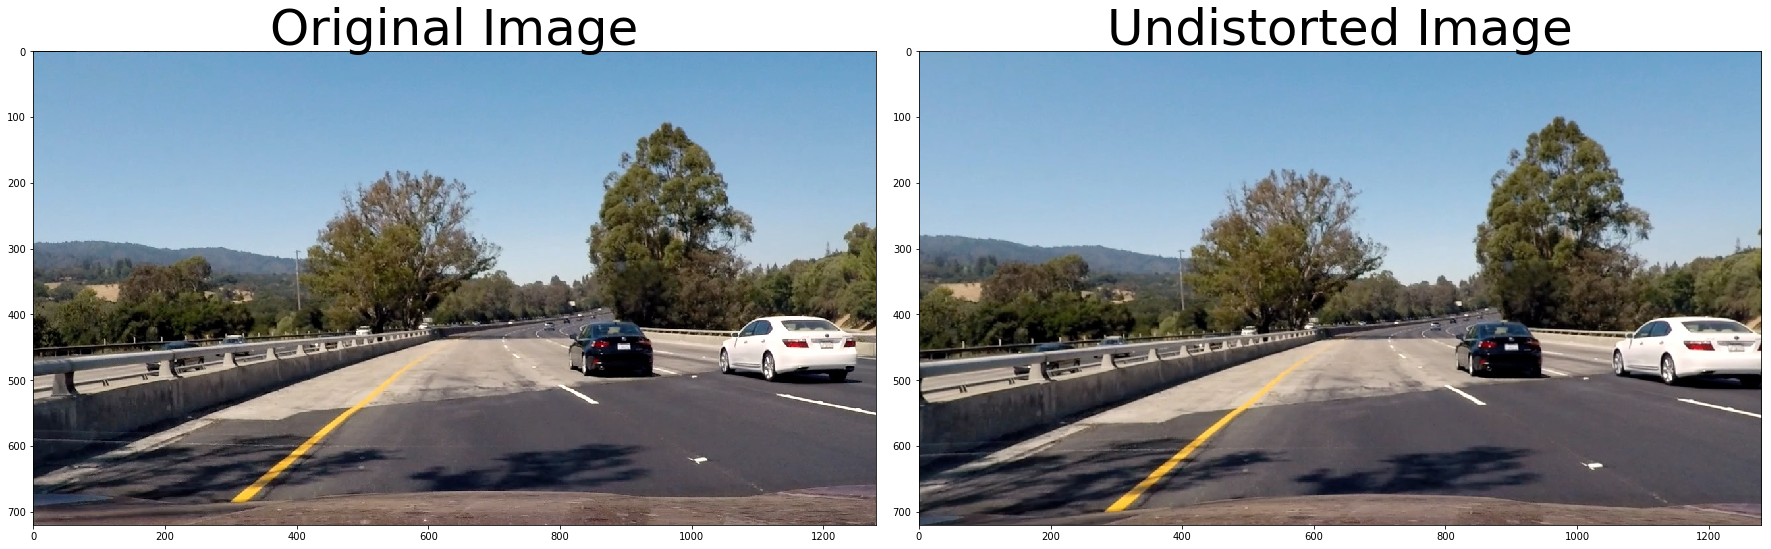

In [75]:
import matplotlib.image as mpimg

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(dst)  # Delete this line
    return undist

img = cv2.imread('/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

undistorted = cal_undistort(img, objpoints, imgpoints)

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistort_output.png')


## 3. Use Color Transforms, Gradients, etc., to create a thresholded binary image.

Now we are going to get the gradient in x axis and y axis and combine with HLS 

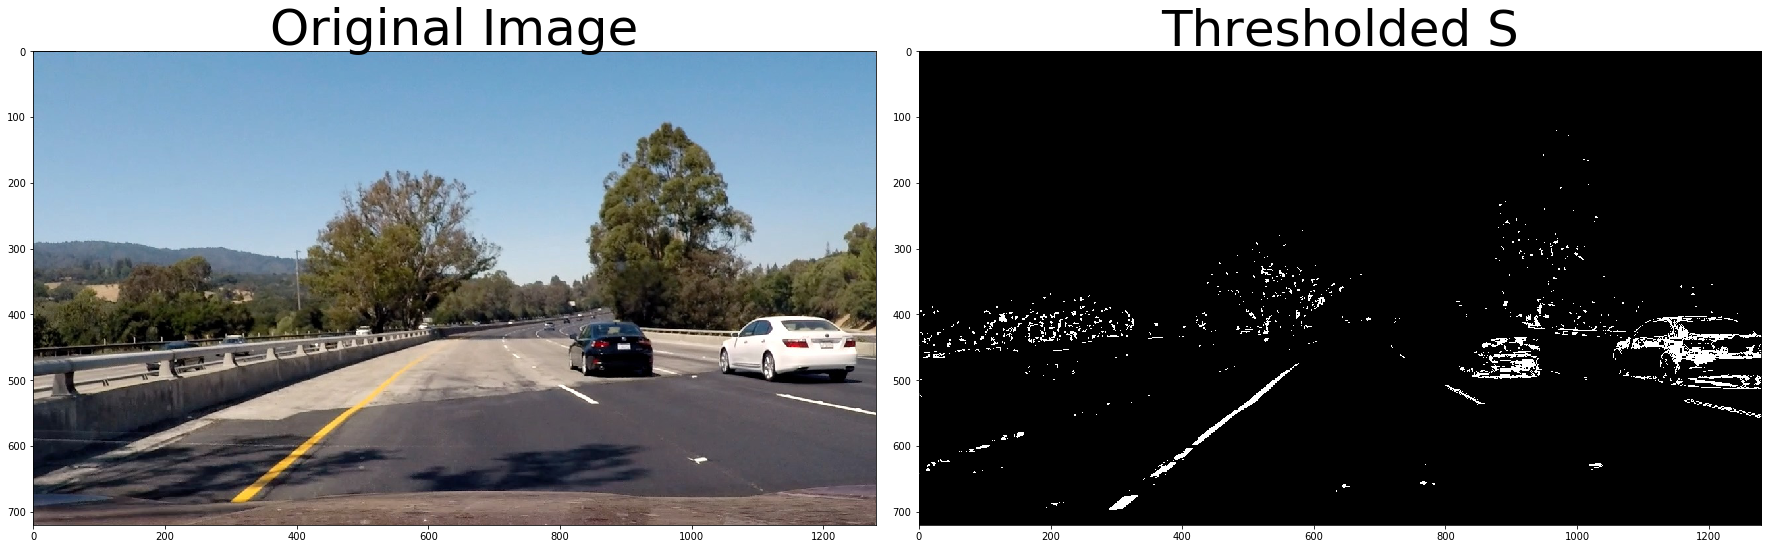

In [77]:
def hls_select(img, Sthresh=(0, 255), mag_thresh=(0, 255), sobel_kernel=3):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(S > Sthresh[0]) & (S <= Sthresh[1])] = 1
    
    # 3) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 4) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 5) Calculate the magnitude 
    sobel = np.sqrt(sobelx**2 + sobely**2)
    #sobel = sobelx
    #sobel = sobely
    # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 7) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    combined_binary = np.zeros_like(sbinary)
    combined_binary[(binary == 1) | (sbinary == 1)] = 1
    
    # 8) Return a binary image of threshold result
    binary_output = np.copy(combined_binary) # placeholder line
    return binary_output
    
hls_binary = hls_select(undistorted, Sthresh=(190, 255), mag_thresh=(160, 255))
#result_path = '/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/output_images/test_out.jpg'

#cv2.imwrite(result_path,hls_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/gradient_binary_result.png')



## 3. Apply a Perspective Transform to Rectify Binary Image

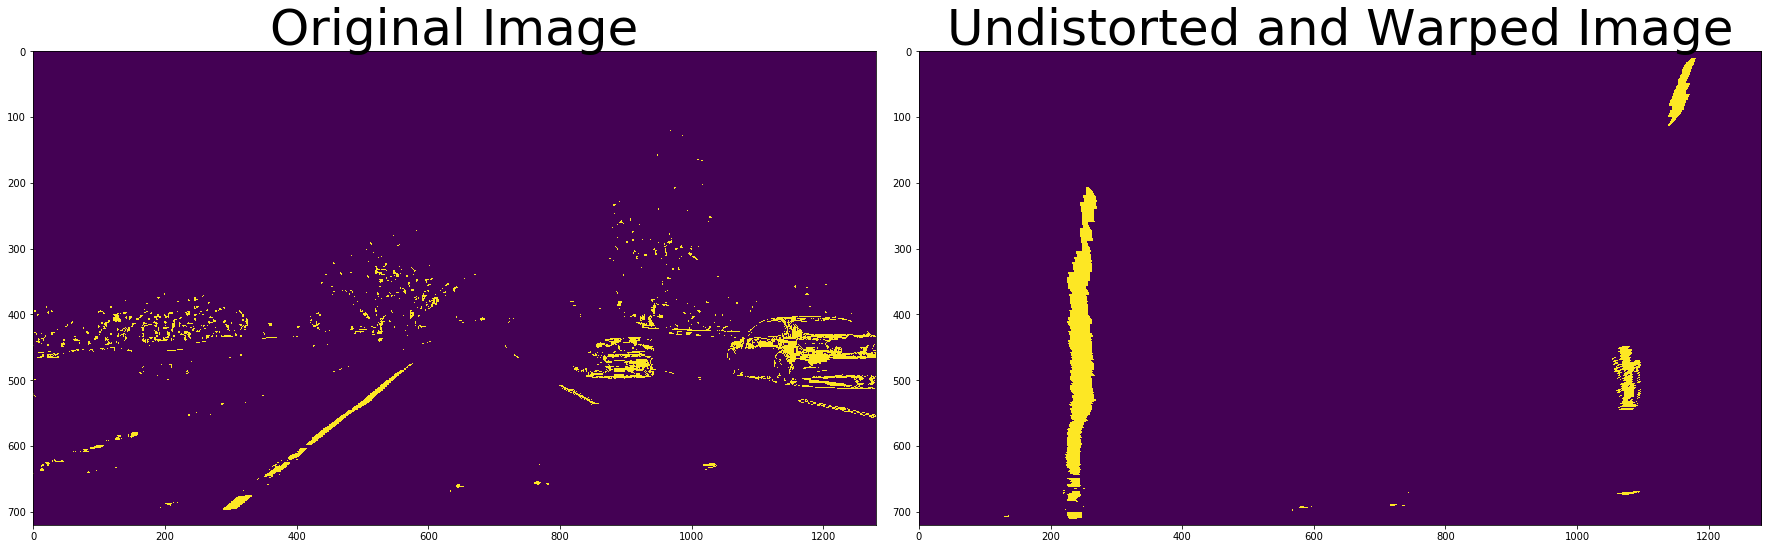

In [78]:
src = np.float32([(580, 460), (205, 720), (1110, 720), (703, 460)])
dst = np.float32([(180, 0), (180, 720), (1000, 720), (1000, 0)])

M = cv2.getPerspectiveTransform(src, dst)   
img_size = (hls_binary.shape[1],hls_binary.shape[0])
warped = cv2.warpPerspective(hls_binary, M, img_size, flags=cv2.INTER_LINEAR)   
            
#delete the next two lines
warped = np.copy(warped) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_binary)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_result.png')

## 4. Detect Lane Pixels and Fit to Find The Lane Boundary.

656.5


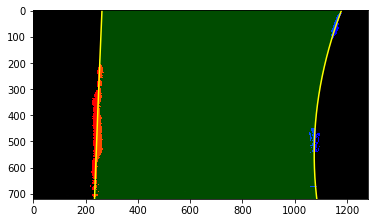

In [61]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
     
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        ### (`right` or `leftx_current`) on their mean position ###

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    
    line_pts = np.hstack((line_window1, line_window2))
    window_img = np.zeros_like(out_img)
     # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    center_of_lane = (leftx[0]+rightx)/2
    

    return result, center_of_lane[0]


out_img, center_of_lane = fit_polynomial(warped)
print(center_of_lane)

plt.imshow(out_img)

## 5. Determine The Curvature of the Lane and Vehicle Position with Respect to Center.

In [62]:
def fit_polynomial_curve(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return ploty, left_fit, right_fit


def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = fit_polynomial_curve(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    
    
    return left_curverad, right_curverad



# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(warped)


print(left_curverad, 'm', right_curverad, 'm')

95915.66495322002 m 1484.6010648380213 m


## 6. Warp the Detected Lane Boundaries Back onto The Original Image.

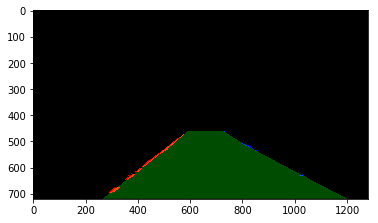

In [63]:
Minv = cv2.getPerspectiveTransform(dst, src)
wrap_img = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(wrap_img)

## 7. Output Visual Display of the Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position.

In [64]:
result = cv2.addWeighted(undistorted,1,wrap_img,1,0) 
offset = 25
cv2.putText(result,'Vehicle is' + str(round(offset,3))+'m'+side_pos+'of center',
            (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
cv2.putText(result,'Radius of curvature:'+str(round((left_curverad + right_curverad)/2))+'m',
            (50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2) 

plt.imshow(result)

NameError: name 'side_pos' is not defined

## 8. Now we build the pipeline and output processed image and save into the output_image folder

True

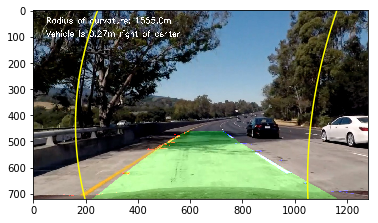

In [65]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    hls_binary = hls_select(undistorted, Sthresh=(220, 255), mag_thresh=(40, 190))
    M = cv2.getPerspectiveTransform(src, dst)   
    img_size = (hls_binary.shape[1],hls_binary.shape[0])
    warped = cv2.warpPerspective(hls_binary, M, img_size, flags=cv2.INTER_LINEAR)   

    out_img, center_of_lane = fit_polynomial(warped)
    left_curverad, right_curverad = measure_curvature_pixels(warped)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    wrap_img = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted,1,wrap_img,1,0) 
    
    xm_per_pix = xm_per_pix = 3.7/700
    offset = (img_size[0]/2 - center_of_lane)*xm_per_pix
 

    side_pos = 'right'
    if offset <0:
        side_pos = 'left'
    
    cv2.putText(result,'Vehicle is ' + str(round(abs(offset),3))+'m '+side_pos+' of center',
            (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
    cv2.putText(result,'Radius of curvature: '+str(round((left_curverad + right_curverad)/2))+'m',
            (50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2) 
    return result


img = cv2.imread('/Users/jianshuwang/Desktop/CarND-Advanced-Lane-Lines/test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
xxx = pipeline(img)
plt.imshow(xxx)
    
xxxx = cv2.cvtColor(xxx, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines2_out.jpg',xxxx)



## 9. Use the pipeline to process the project_video.mp4 and save the output into the output image folder
From the output video, this algorithms and parameters can do a very good job for the source video.

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [05:25<00:00,  3.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 19min 55s, sys: 1min 52s, total: 21min 47s
Wall time: 5min 26s


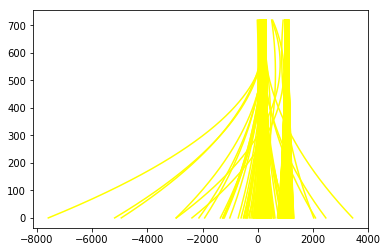

In [66]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

white_output = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## 10. Use the pipeline to process the challenge_video.mp4 and save the output into the output image folder
My algorithms does not do a good job for the 2 challenge videos, I think I just need to adjust parameters.

[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4


100%|██████████| 485/485 [02:05<00:00,  3.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video_output.mp4 

CPU times: user 4min 38s, sys: 41.7 s, total: 5min 20s
Wall time: 2min 6s


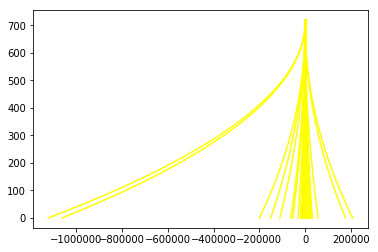

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

white_output = 'output_images/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## 11. Use the pipeline to process the challenge_video.mp4 and save the output into the output image folder


512.5
[MoviePy] >>>> Building video output_images/harder_challenge_video_output.mp4
[MoviePy] Writing video output_images/harder_challenge_video_output.mp4


  0%|          | 1/1200 [00:00<06:27,  3.09it/s]

512.5


  0%|          | 2/1200 [00:00<06:21,  3.14it/s]

517.0


  0%|          | 3/1200 [00:00<06:21,  3.14it/s]

519.0


  0%|          | 4/1200 [00:01<06:21,  3.14it/s]

517.5


  0%|          | 5/1200 [00:01<06:12,  3.21it/s]

516.5


  0%|          | 6/1200 [00:01<06:13,  3.20it/s]

518.0


  1%|          | 7/1200 [00:02<06:10,  3.22it/s]

516.0


  1%|          | 8/1200 [00:02<06:02,  3.29it/s]

517.0


  1%|          | 9/1200 [00:02<06:01,  3.29it/s]

517.5


  1%|          | 10/1200 [00:03<06:07,  3.24it/s]

516.0


  1%|          | 11/1200 [00:03<05:56,  3.33it/s]

509.0


  1%|          | 12/1200 [00:03<06:08,  3.22it/s]

513.0


  1%|          | 13/1200 [00:04<06:18,  3.14it/s]

512.0


  1%|          | 14/1200 [00:04<06:20,  3.12it/s]

510.5


  1%|▏         | 15/1200 [00:04<06:07,  3.23it/s]

509.5


  1%|▏         | 16/1200 [00:04<05:56,  3.32it/s]

506.5


  1%|▏         | 17/1200 [00:05<05:48,  3.39it/s]

505.5


  2%|▏         | 18/1200 [00:05<05:39,  3.48it/s]

506.0


  2%|▏         | 19/1200 [00:05<05:36,  3.51it/s]

491.5


  2%|▏         | 20/1200 [00:06<05:33,  3.54it/s]

501.0


  2%|▏         | 21/1200 [00:06<05:33,  3.54it/s]

498.0


  2%|▏         | 22/1200 [00:06<05:31,  3.56it/s]

495.5


  2%|▏         | 23/1200 [00:06<05:32,  3.54it/s]

493.0


  2%|▏         | 24/1200 [00:07<05:33,  3.52it/s]

490.0


  2%|▏         | 25/1200 [00:07<05:38,  3.47it/s]

488.5


  2%|▏         | 26/1200 [00:07<05:35,  3.50it/s]

487.0


  2%|▏         | 27/1200 [00:08<05:33,  3.51it/s]

487.0


  2%|▏         | 28/1200 [00:08<05:30,  3.54it/s]

449.5


  2%|▏         | 29/1200 [00:08<05:28,  3.56it/s]

482.5


  2%|▎         | 30/1200 [00:08<05:28,  3.56it/s]

480.5


  3%|▎         | 31/1200 [00:09<05:24,  3.60it/s]

485.0


  3%|▎         | 32/1200 [00:09<05:15,  3.70it/s]

499.5


  3%|▎         | 33/1200 [00:09<05:11,  3.74it/s]

491.5


  3%|▎         | 34/1200 [00:09<05:27,  3.57it/s]

475.5


  3%|▎         | 35/1200 [00:10<05:31,  3.52it/s]

495.0


  3%|▎         | 36/1200 [00:10<05:42,  3.40it/s]

496.0


  3%|▎         | 37/1200 [00:10<05:36,  3.46it/s]

498.0


  3%|▎         | 38/1200 [00:11<05:31,  3.51it/s]

499.0


  3%|▎         | 39/1200 [00:11<05:27,  3.55it/s]

500.0


  3%|▎         | 40/1200 [00:11<05:19,  3.63it/s]

502.0


  3%|▎         | 41/1200 [00:11<05:17,  3.65it/s]

502.5


  4%|▎         | 42/1200 [00:12<05:17,  3.65it/s]

496.0


  4%|▎         | 43/1200 [00:12<05:28,  3.52it/s]

505.0


  4%|▎         | 44/1200 [00:12<05:26,  3.54it/s]

494.5


  4%|▍         | 45/1200 [00:13<05:43,  3.36it/s]

498.0


  4%|▍         | 46/1200 [00:13<05:35,  3.44it/s]

508.5


  4%|▍         | 47/1200 [00:13<05:35,  3.43it/s]

516.5


  4%|▍         | 48/1200 [00:13<05:39,  3.40it/s]

528.0


  4%|▍         | 49/1200 [00:14<05:35,  3.43it/s]

471.5


  4%|▍         | 50/1200 [00:14<05:28,  3.50it/s]

516.5


  4%|▍         | 51/1200 [00:14<05:26,  3.52it/s]

517.0


  4%|▍         | 52/1200 [00:15<05:28,  3.49it/s]

504.0


  4%|▍         | 53/1200 [00:15<05:48,  3.30it/s]

517.5


  4%|▍         | 54/1200 [00:15<05:43,  3.34it/s]

520.0


  5%|▍         | 55/1200 [00:16<05:45,  3.31it/s]

520.5


  5%|▍         | 56/1200 [00:16<05:45,  3.31it/s]

523.5


  5%|▍         | 57/1200 [00:16<05:38,  3.38it/s]

524.5


  5%|▍         | 58/1200 [00:16<05:47,  3.28it/s]

527.0


  5%|▍         | 59/1200 [00:17<05:47,  3.29it/s]

527.5


  5%|▌         | 60/1200 [00:17<05:45,  3.30it/s]

527.5


  5%|▌         | 61/1200 [00:17<05:49,  3.26it/s]

541.5


  5%|▌         | 62/1200 [00:18<05:45,  3.30it/s]

545.5


  5%|▌         | 63/1200 [00:18<05:45,  3.29it/s]

548.5


  5%|▌         | 64/1200 [00:18<05:52,  3.22it/s]

595.0


  5%|▌         | 65/1200 [00:19<05:47,  3.27it/s]

633.0


  6%|▌         | 66/1200 [00:19<05:40,  3.33it/s]

627.5


  6%|▌         | 67/1200 [00:19<05:43,  3.30it/s]

537.0


  6%|▌         | 68/1200 [00:20<05:42,  3.31it/s]

531.0


  6%|▌         | 69/1200 [00:20<05:33,  3.39it/s]

644.5


  6%|▌         | 70/1200 [00:20<05:40,  3.32it/s]

665.0


  6%|▌         | 71/1200 [00:20<05:33,  3.39it/s]

567.5


  6%|▌         | 72/1200 [00:21<05:29,  3.43it/s]

522.0


  6%|▌         | 73/1200 [00:21<05:26,  3.45it/s]

549.0


  6%|▌         | 74/1200 [00:21<05:28,  3.43it/s]

552.5


  6%|▋         | 75/1200 [00:22<05:29,  3.41it/s]

551.5


  6%|▋         | 76/1200 [00:22<05:29,  3.41it/s]

552.5


  6%|▋         | 77/1200 [00:22<05:24,  3.46it/s]

551.0


  6%|▋         | 78/1200 [00:22<05:24,  3.46it/s]

462.5


  7%|▋         | 79/1200 [00:23<05:19,  3.51it/s]

550.5


  7%|▋         | 80/1200 [00:23<05:17,  3.53it/s]

551.5


  7%|▋         | 81/1200 [00:23<05:13,  3.57it/s]

543.0


  7%|▋         | 82/1200 [00:24<05:13,  3.57it/s]

526.0


  7%|▋         | 83/1200 [00:24<05:10,  3.60it/s]

487.5


  7%|▋         | 84/1200 [00:24<05:11,  3.59it/s]

594.0


  7%|▋         | 85/1200 [00:24<05:08,  3.61it/s]

574.5


  7%|▋         | 86/1200 [00:25<05:07,  3.63it/s]

569.0


  7%|▋         | 87/1200 [00:25<05:05,  3.64it/s]

567.5


  7%|▋         | 88/1200 [00:25<05:08,  3.61it/s]

519.5


  7%|▋         | 89/1200 [00:25<05:12,  3.55it/s]

540.0


  8%|▊         | 90/1200 [00:26<05:21,  3.45it/s]

537.0


  8%|▊         | 91/1200 [00:26<05:18,  3.48it/s]

531.0


  8%|▊         | 92/1200 [00:26<05:17,  3.49it/s]

658.5


  8%|▊         | 93/1200 [00:27<05:15,  3.50it/s]

543.0


  8%|▊         | 94/1200 [00:27<05:14,  3.51it/s]

524.0


  8%|▊         | 95/1200 [00:27<05:20,  3.45it/s]

500.5


  8%|▊         | 96/1200 [00:28<05:28,  3.36it/s]

523.5


  8%|▊         | 97/1200 [00:28<05:27,  3.37it/s]

675.5


  8%|▊         | 98/1200 [00:28<05:31,  3.33it/s]

669.0


  8%|▊         | 99/1200 [00:28<05:20,  3.44it/s]

582.5


  8%|▊         | 100/1200 [00:29<05:17,  3.46it/s]

584.5


  8%|▊         | 101/1200 [00:29<05:13,  3.50it/s]

656.0


  8%|▊         | 102/1200 [00:29<05:25,  3.37it/s]

592.0


  9%|▊         | 103/1200 [00:30<05:16,  3.46it/s]

621.0


  9%|▊         | 104/1200 [00:30<05:20,  3.42it/s]

626.5


  9%|▉         | 105/1200 [00:30<05:16,  3.46it/s]

626.0


  9%|▉         | 106/1200 [00:30<05:12,  3.51it/s]

660.5


  9%|▉         | 107/1200 [00:31<05:19,  3.42it/s]

606.5


  9%|▉         | 108/1200 [00:31<05:18,  3.43it/s]

645.5


  9%|▉         | 109/1200 [00:31<05:18,  3.43it/s]

660.5


  9%|▉         | 110/1200 [00:32<05:13,  3.47it/s]

632.5


  9%|▉         | 111/1200 [00:32<05:11,  3.50it/s]

645.5


  9%|▉         | 112/1200 [00:32<06:16,  2.89it/s]

901.5


  9%|▉         | 113/1200 [00:33<05:52,  3.09it/s]

446.0


 10%|▉         | 114/1200 [00:33<05:33,  3.26it/s]

453.5


 10%|▉         | 115/1200 [00:33<05:18,  3.41it/s]

360.0


 10%|▉         | 116/1200 [00:33<05:12,  3.47it/s]

315.0


 10%|▉         | 117/1200 [00:34<05:05,  3.55it/s]

328.5


 10%|▉         | 118/1200 [00:34<05:01,  3.59it/s]

342.0


 10%|▉         | 119/1200 [00:34<04:58,  3.62it/s]

438.5


 10%|█         | 120/1200 [00:35<04:59,  3.60it/s]

500.5


 10%|█         | 121/1200 [00:35<04:57,  3.62it/s]

501.5


 10%|█         | 122/1200 [00:35<04:59,  3.59it/s]

509.0


 10%|█         | 123/1200 [00:35<05:04,  3.54it/s]

533.0


 10%|█         | 124/1200 [00:36<05:08,  3.48it/s]

530.0


 10%|█         | 125/1200 [00:36<05:08,  3.48it/s]

548.5


 10%|█         | 126/1200 [00:36<05:06,  3.50it/s]

528.0


 11%|█         | 127/1200 [00:37<05:15,  3.40it/s]

532.0


 11%|█         | 128/1200 [00:37<05:12,  3.43it/s]

539.0


 11%|█         | 129/1200 [00:37<05:13,  3.42it/s]

542.0


 11%|█         | 130/1200 [00:37<05:05,  3.50it/s]

545.0


 11%|█         | 131/1200 [00:38<04:59,  3.56it/s]

553.5


 11%|█         | 132/1200 [00:38<04:54,  3.63it/s]

589.5


 11%|█         | 133/1200 [00:38<04:53,  3.64it/s]

560.0


 11%|█         | 134/1200 [00:38<04:52,  3.64it/s]

563.5


 11%|█▏        | 135/1200 [00:39<04:46,  3.72it/s]

568.0


 11%|█▏        | 136/1200 [00:39<04:41,  3.78it/s]

573.5


 11%|█▏        | 137/1200 [00:39<04:41,  3.77it/s]

578.0


 12%|█▏        | 138/1200 [00:40<04:42,  3.76it/s]

581.0


 12%|█▏        | 139/1200 [00:40<04:39,  3.79it/s]

583.0


 12%|█▏        | 140/1200 [00:40<04:42,  3.76it/s]

593.0


 12%|█▏        | 141/1200 [00:40<04:44,  3.72it/s]

591.5


 12%|█▏        | 142/1200 [00:41<04:49,  3.66it/s]

596.0


 12%|█▏        | 143/1200 [00:41<04:46,  3.69it/s]

599.0


 12%|█▏        | 144/1200 [00:41<04:49,  3.65it/s]

604.0


 12%|█▏        | 145/1200 [00:41<04:51,  3.62it/s]

607.0


 12%|█▏        | 146/1200 [00:42<04:57,  3.54it/s]

611.0


 12%|█▏        | 147/1200 [00:42<04:58,  3.52it/s]

614.0


 12%|█▏        | 148/1200 [00:42<05:01,  3.48it/s]

617.5


 12%|█▏        | 149/1200 [00:43<05:08,  3.41it/s]

620.5


 12%|█▎        | 150/1200 [00:43<05:16,  3.32it/s]

625.0


 13%|█▎        | 151/1200 [00:43<05:22,  3.26it/s]

626.5


 13%|█▎        | 152/1200 [00:44<05:23,  3.24it/s]

365.5


 13%|█▎        | 153/1200 [00:44<05:23,  3.24it/s]

365.5


 13%|█▎        | 154/1200 [00:44<05:21,  3.26it/s]

365.0


 13%|█▎        | 155/1200 [00:44<05:16,  3.31it/s]

429.0


 13%|█▎        | 156/1200 [00:45<05:13,  3.32it/s]

369.0


 13%|█▎        | 157/1200 [00:45<05:06,  3.41it/s]

431.0


 13%|█▎        | 158/1200 [00:45<04:59,  3.48it/s]

383.0


 13%|█▎        | 159/1200 [00:46<04:57,  3.50it/s]

434.5


 13%|█▎        | 160/1200 [00:46<04:51,  3.57it/s]

437.5


 13%|█▎        | 161/1200 [00:46<04:48,  3.60it/s]

400.0


 14%|█▎        | 162/1200 [00:46<04:42,  3.67it/s]

404.5


 14%|█▎        | 163/1200 [00:47<04:35,  3.76it/s]

486.0


 14%|█▎        | 164/1200 [00:47<04:34,  3.78it/s]

394.0


 14%|█▍        | 165/1200 [00:47<04:37,  3.73it/s]

426.0


 14%|█▍        | 166/1200 [00:47<04:38,  3.71it/s]

425.5


 14%|█▍        | 167/1200 [00:48<04:37,  3.72it/s]

405.0


 14%|█▍        | 168/1200 [00:48<04:35,  3.75it/s]

410.5


 14%|█▍        | 169/1200 [00:48<04:35,  3.74it/s]

417.5


 14%|█▍        | 170/1200 [00:49<04:45,  3.61it/s]

393.5


 14%|█▍        | 171/1200 [00:49<04:47,  3.57it/s]

685.0


 14%|█▍        | 172/1200 [00:49<04:49,  3.55it/s]

689.5


 14%|█▍        | 173/1200 [00:49<04:56,  3.46it/s]

428.0


 14%|█▍        | 174/1200 [00:50<04:59,  3.42it/s]

405.0


 15%|█▍        | 175/1200 [00:50<04:53,  3.49it/s]

408.5


 15%|█▍        | 176/1200 [00:50<04:48,  3.55it/s]

704.0


 15%|█▍        | 177/1200 [00:51<04:46,  3.57it/s]

703.5


 15%|█▍        | 178/1200 [00:51<04:49,  3.53it/s]

412.5


 15%|█▍        | 179/1200 [00:51<04:40,  3.64it/s]

712.0


 15%|█▌        | 180/1200 [00:51<04:39,  3.64it/s]

712.5


 15%|█▌        | 181/1200 [00:52<04:35,  3.70it/s]

330.5


 15%|█▌        | 182/1200 [00:52<04:32,  3.74it/s]

715.5


 15%|█▌        | 183/1200 [00:52<04:27,  3.80it/s]

723.5


 15%|█▌        | 184/1200 [00:52<04:25,  3.82it/s]

428.5


 15%|█▌        | 185/1200 [00:53<04:30,  3.75it/s]

428.5


 16%|█▌        | 186/1200 [00:53<04:31,  3.74it/s]

428.5


 16%|█▌        | 187/1200 [00:53<04:36,  3.66it/s]

747.5


 16%|█▌        | 188/1200 [00:54<04:38,  3.63it/s]

429.0


 16%|█▌        | 189/1200 [00:54<04:42,  3.58it/s]

746.0


 16%|█▌        | 190/1200 [00:54<04:49,  3.49it/s]

455.5


 16%|█▌        | 191/1200 [00:54<04:47,  3.51it/s]

522.0


 16%|█▌        | 192/1200 [00:55<04:50,  3.47it/s]

410.5


 16%|█▌        | 193/1200 [00:55<04:52,  3.45it/s]

586.0


 16%|█▌        | 194/1200 [00:55<04:52,  3.43it/s]

567.0


 16%|█▋        | 195/1200 [00:56<04:49,  3.48it/s]

685.0


 16%|█▋        | 196/1200 [00:56<04:49,  3.47it/s]

642.5


 16%|█▋        | 197/1200 [00:56<04:59,  3.35it/s]

641.5


 16%|█▋        | 198/1200 [00:56<04:59,  3.35it/s]

761.0


 17%|█▋        | 199/1200 [00:57<05:00,  3.33it/s]

708.0


 17%|█▋        | 200/1200 [00:57<05:08,  3.24it/s]

689.0


 17%|█▋        | 201/1200 [00:57<05:08,  3.24it/s]

623.5


 17%|█▋        | 202/1200 [00:58<05:04,  3.28it/s]

592.5


 17%|█▋        | 203/1200 [00:58<04:59,  3.33it/s]

526.0


 17%|█▋        | 204/1200 [00:58<05:04,  3.27it/s]

827.0


 17%|█▋        | 205/1200 [00:59<05:07,  3.24it/s]

803.0


 17%|█▋        | 206/1200 [00:59<05:02,  3.28it/s]

700.0


 17%|█▋        | 207/1200 [00:59<05:00,  3.31it/s]

673.5


 17%|█▋        | 208/1200 [01:00<04:57,  3.33it/s]

655.5


 17%|█▋        | 209/1200 [01:00<04:52,  3.38it/s]

632.5


 18%|█▊        | 210/1200 [01:00<04:49,  3.42it/s]

638.0


 18%|█▊        | 211/1200 [01:00<04:48,  3.43it/s]

626.0


 18%|█▊        | 212/1200 [01:01<04:56,  3.33it/s]

626.0


 18%|█▊        | 213/1200 [01:01<04:59,  3.29it/s]

614.0


 18%|█▊        | 214/1200 [01:01<05:03,  3.25it/s]

604.0


 18%|█▊        | 215/1200 [01:02<05:03,  3.25it/s]

585.0


 18%|█▊        | 216/1200 [01:02<05:05,  3.22it/s]

566.5


 18%|█▊        | 217/1200 [01:02<05:09,  3.17it/s]

565.0


 18%|█▊        | 218/1200 [01:03<05:08,  3.18it/s]

555.0


 18%|█▊        | 219/1200 [01:03<05:14,  3.12it/s]

637.0


 18%|█▊        | 220/1200 [01:03<05:07,  3.19it/s]

637.5


 18%|█▊        | 221/1200 [01:04<05:05,  3.20it/s]

865.5


 18%|█▊        | 222/1200 [01:04<05:08,  3.17it/s]

857.5


 19%|█▊        | 223/1200 [01:04<05:02,  3.23it/s]

758.5


 19%|█▊        | 224/1200 [01:04<04:59,  3.26it/s]

698.5


 19%|█▉        | 225/1200 [01:05<05:00,  3.24it/s]

838.5


 19%|█▉        | 226/1200 [01:05<05:01,  3.23it/s]

751.0


 19%|█▉        | 227/1200 [01:05<04:57,  3.27it/s]

852.5


 19%|█▉        | 228/1200 [01:06<04:58,  3.25it/s]

815.0


 19%|█▉        | 229/1200 [01:06<04:52,  3.32it/s]

773.0


 19%|█▉        | 230/1200 [01:06<04:52,  3.32it/s]

788.0


 19%|█▉        | 231/1200 [01:07<04:49,  3.35it/s]

765.0


 19%|█▉        | 232/1200 [01:07<04:43,  3.41it/s]

772.5


 19%|█▉        | 233/1200 [01:07<04:42,  3.42it/s]

798.5


 20%|█▉        | 234/1200 [01:07<04:38,  3.46it/s]

799.5


 20%|█▉        | 235/1200 [01:08<04:36,  3.49it/s]

807.0


 20%|█▉        | 236/1200 [01:08<04:32,  3.53it/s]

601.0


 20%|█▉        | 237/1200 [01:08<04:35,  3.49it/s]

500.5


 20%|█▉        | 238/1200 [01:09<04:37,  3.47it/s]

501.0


 20%|█▉        | 239/1200 [01:09<04:39,  3.44it/s]

726.5


 20%|██        | 240/1200 [01:09<04:37,  3.46it/s]

433.5


 20%|██        | 241/1200 [01:09<04:43,  3.39it/s]

724.5


 20%|██        | 242/1200 [01:10<04:39,  3.43it/s]

499.5


 20%|██        | 243/1200 [01:10<04:39,  3.43it/s]

500.5


 20%|██        | 244/1200 [01:10<04:37,  3.44it/s]

500.0


 20%|██        | 245/1200 [01:11<04:39,  3.42it/s]

501.0


 20%|██        | 246/1200 [01:11<04:36,  3.46it/s]

506.5


 21%|██        | 247/1200 [01:11<04:35,  3.46it/s]

505.0


 21%|██        | 248/1200 [01:11<04:33,  3.49it/s]

487.5


 21%|██        | 249/1200 [01:12<04:33,  3.48it/s]

507.0


 21%|██        | 250/1200 [01:12<04:31,  3.49it/s]

511.5


 21%|██        | 251/1200 [01:12<04:33,  3.46it/s]

491.5


 21%|██        | 252/1200 [01:13<04:34,  3.45it/s]

514.0


 21%|██        | 253/1200 [01:13<04:35,  3.44it/s]

482.0


 21%|██        | 254/1200 [01:13<04:36,  3.42it/s]

511.5


 21%|██▏       | 255/1200 [01:14<04:34,  3.45it/s]

512.0


 21%|██▏       | 256/1200 [01:14<04:31,  3.48it/s]

469.0


 21%|██▏       | 257/1200 [01:14<04:29,  3.50it/s]

510.5


 22%|██▏       | 258/1200 [01:14<04:28,  3.51it/s]

451.0


 22%|██▏       | 259/1200 [01:15<04:25,  3.55it/s]

516.5


 22%|██▏       | 260/1200 [01:15<04:24,  3.56it/s]

516.5


 22%|██▏       | 261/1200 [01:15<04:25,  3.54it/s]

491.5


 22%|██▏       | 262/1200 [01:15<04:28,  3.49it/s]

490.0


 22%|██▏       | 263/1200 [01:16<04:28,  3.49it/s]

499.5


 22%|██▏       | 264/1200 [01:16<04:22,  3.56it/s]

502.5


 22%|██▏       | 265/1200 [01:16<04:24,  3.53it/s]

488.0


 22%|██▏       | 266/1200 [01:17<04:21,  3.57it/s]

735.0


 22%|██▏       | 267/1200 [01:17<04:19,  3.59it/s]

706.5


 22%|██▏       | 268/1200 [01:17<04:21,  3.57it/s]

712.5


 22%|██▏       | 269/1200 [01:17<04:20,  3.57it/s]

720.5


 22%|██▎       | 270/1200 [01:18<04:18,  3.59it/s]

510.5


 23%|██▎       | 271/1200 [01:18<04:17,  3.61it/s]

522.0


 23%|██▎       | 272/1200 [01:18<04:18,  3.58it/s]

731.0


 23%|██▎       | 273/1200 [01:19<04:16,  3.62it/s]

799.0


 23%|██▎       | 274/1200 [01:19<04:13,  3.65it/s]

732.5


 23%|██▎       | 275/1200 [01:19<04:13,  3.65it/s]

836.0


 23%|██▎       | 276/1200 [01:19<04:16,  3.61it/s]

807.0


 23%|██▎       | 277/1200 [01:20<04:14,  3.62it/s]

407.5


 23%|██▎       | 278/1200 [01:20<04:14,  3.62it/s]

623.5


 23%|██▎       | 279/1200 [01:20<04:13,  3.63it/s]

530.5


 23%|██▎       | 280/1200 [01:20<04:12,  3.65it/s]

565.0


 23%|██▎       | 281/1200 [01:21<04:13,  3.62it/s]

547.0


 24%|██▎       | 282/1200 [01:21<04:11,  3.64it/s]

586.5


 24%|██▎       | 283/1200 [01:21<04:07,  3.71it/s]

610.0


 24%|██▎       | 284/1200 [01:22<04:06,  3.71it/s]

617.0


 24%|██▍       | 285/1200 [01:22<04:10,  3.66it/s]

631.0


 24%|██▍       | 286/1200 [01:22<04:12,  3.61it/s]

613.0


 24%|██▍       | 287/1200 [01:22<04:11,  3.63it/s]

587.0


 24%|██▍       | 288/1200 [01:23<04:08,  3.66it/s]

574.0


 24%|██▍       | 289/1200 [01:23<04:07,  3.69it/s]

650.5


 24%|██▍       | 290/1200 [01:23<04:08,  3.65it/s]

643.5


 24%|██▍       | 291/1200 [01:23<04:06,  3.69it/s]

692.5


 24%|██▍       | 292/1200 [01:24<04:03,  3.73it/s]

689.0


 24%|██▍       | 293/1200 [01:24<04:03,  3.73it/s]

722.0


 24%|██▍       | 294/1200 [01:24<04:04,  3.71it/s]

414.5


 25%|██▍       | 295/1200 [01:25<04:04,  3.70it/s]

442.5


 25%|██▍       | 296/1200 [01:25<04:02,  3.72it/s]

444.5


 25%|██▍       | 297/1200 [01:25<03:59,  3.77it/s]

441.5


 25%|██▍       | 298/1200 [01:25<03:57,  3.80it/s]

525.0


 25%|██▍       | 299/1200 [01:26<03:55,  3.82it/s]

521.5


 25%|██▌       | 300/1200 [01:26<03:56,  3.81it/s]

542.0


 25%|██▌       | 301/1200 [01:26<03:53,  3.85it/s]

473.0


 25%|██▌       | 302/1200 [01:26<03:51,  3.88it/s]

529.0


 25%|██▌       | 303/1200 [01:27<03:51,  3.87it/s]

545.5


 25%|██▌       | 304/1200 [01:27<03:53,  3.84it/s]

559.5


 25%|██▌       | 305/1200 [01:27<03:51,  3.87it/s]

549.0


 26%|██▌       | 306/1200 [01:27<03:52,  3.85it/s]

553.5


 26%|██▌       | 307/1200 [01:28<03:49,  3.89it/s]

587.5


 26%|██▌       | 308/1200 [01:28<03:49,  3.89it/s]

554.0


 26%|██▌       | 309/1200 [01:28<03:51,  3.85it/s]

578.5


 26%|██▌       | 310/1200 [01:28<03:50,  3.87it/s]

552.5


 26%|██▌       | 311/1200 [01:29<03:49,  3.87it/s]

561.5


 26%|██▌       | 312/1200 [01:29<03:51,  3.84it/s]

554.5


 26%|██▌       | 313/1200 [01:29<03:50,  3.84it/s]

566.0


 26%|██▌       | 314/1200 [01:29<03:50,  3.85it/s]

592.0


 26%|██▋       | 315/1200 [01:30<03:50,  3.84it/s]

593.5


 26%|██▋       | 316/1200 [01:30<03:49,  3.85it/s]

544.0


 26%|██▋       | 317/1200 [01:30<03:49,  3.85it/s]

571.0


 26%|██▋       | 318/1200 [01:30<03:48,  3.86it/s]

573.0


 27%|██▋       | 319/1200 [01:31<03:46,  3.89it/s]

574.5


 27%|██▋       | 320/1200 [01:31<03:48,  3.85it/s]

575.5


 27%|██▋       | 321/1200 [01:31<03:56,  3.72it/s]

579.5


 27%|██▋       | 322/1200 [01:32<03:58,  3.69it/s]

580.5


 27%|██▋       | 323/1200 [01:32<04:00,  3.65it/s]

579.5


 27%|██▋       | 324/1200 [01:32<04:04,  3.59it/s]

751.5


 27%|██▋       | 325/1200 [01:32<04:03,  3.59it/s]

745.5


 27%|██▋       | 326/1200 [01:33<04:04,  3.57it/s]

713.0


 27%|██▋       | 327/1200 [01:33<04:05,  3.56it/s]

759.5


 27%|██▋       | 328/1200 [01:33<04:07,  3.53it/s]

742.5


 27%|██▋       | 329/1200 [01:34<04:07,  3.52it/s]

711.0


 28%|██▊       | 330/1200 [01:34<04:02,  3.58it/s]

743.5


 28%|██▊       | 331/1200 [01:34<03:57,  3.66it/s]

756.0


 28%|██▊       | 332/1200 [01:34<03:55,  3.68it/s]

792.5


 28%|██▊       | 333/1200 [01:35<03:53,  3.71it/s]

769.5


 28%|██▊       | 334/1200 [01:35<03:52,  3.73it/s]

781.5


 28%|██▊       | 335/1200 [01:35<03:50,  3.76it/s]

765.5


 28%|██▊       | 336/1200 [01:35<03:50,  3.75it/s]

745.5


 28%|██▊       | 337/1200 [01:36<03:47,  3.80it/s]

761.5


 28%|██▊       | 338/1200 [01:36<03:46,  3.81it/s]

762.5


 28%|██▊       | 339/1200 [01:36<03:43,  3.85it/s]

761.5


 28%|██▊       | 340/1200 [01:36<03:42,  3.87it/s]

757.5


 28%|██▊       | 341/1200 [01:37<03:40,  3.89it/s]

765.5


 28%|██▊       | 342/1200 [01:37<03:41,  3.88it/s]

710.5


 29%|██▊       | 343/1200 [01:37<03:42,  3.86it/s]

675.5


 29%|██▊       | 344/1200 [01:37<03:40,  3.88it/s]

667.0


 29%|██▉       | 345/1200 [01:38<03:40,  3.88it/s]

655.0


 29%|██▉       | 346/1200 [01:38<03:38,  3.92it/s]

477.5


 29%|██▉       | 347/1200 [01:38<03:39,  3.89it/s]

419.0


 29%|██▉       | 348/1200 [01:39<03:41,  3.84it/s]

501.0


 29%|██▉       | 349/1200 [01:39<03:38,  3.90it/s]

752.5


 29%|██▉       | 350/1200 [01:39<03:36,  3.93it/s]

693.0


 29%|██▉       | 351/1200 [01:39<03:36,  3.92it/s]

716.5


 29%|██▉       | 352/1200 [01:40<03:37,  3.91it/s]

685.5


 29%|██▉       | 353/1200 [01:40<03:36,  3.92it/s]

709.0


 30%|██▉       | 354/1200 [01:40<03:36,  3.92it/s]

676.5


 30%|██▉       | 355/1200 [01:40<03:36,  3.90it/s]

691.5


 30%|██▉       | 356/1200 [01:41<03:37,  3.88it/s]

665.0


 30%|██▉       | 357/1200 [01:41<03:42,  3.80it/s]

666.5


 30%|██▉       | 358/1200 [01:41<03:43,  3.77it/s]

723.0


 30%|██▉       | 359/1200 [01:41<03:46,  3.71it/s]

724.5


 30%|███       | 360/1200 [01:42<03:45,  3.72it/s]

832.0


 30%|███       | 361/1200 [01:42<03:45,  3.72it/s]

749.0


 30%|███       | 362/1200 [01:42<03:43,  3.75it/s]

672.5


 30%|███       | 363/1200 [01:42<03:44,  3.72it/s]

585.5


 30%|███       | 364/1200 [01:43<03:49,  3.65it/s]

500.0


 30%|███       | 365/1200 [01:43<03:52,  3.59it/s]

435.5


 30%|███       | 366/1200 [01:43<03:57,  3.52it/s]

526.0


 31%|███       | 367/1200 [01:44<04:01,  3.45it/s]

490.5


 31%|███       | 368/1200 [01:44<04:08,  3.35it/s]

573.0


 31%|███       | 369/1200 [01:44<04:23,  3.15it/s]

556.0


 31%|███       | 370/1200 [01:45<04:28,  3.09it/s]

897.0


 31%|███       | 371/1200 [01:45<04:35,  3.01it/s]

886.5


 31%|███       | 372/1200 [01:45<04:40,  2.95it/s]

839.0


 31%|███       | 373/1200 [01:46<04:47,  2.88it/s]

548.5


 31%|███       | 374/1200 [01:46<04:56,  2.78it/s]

525.5


 31%|███▏      | 375/1200 [01:47<05:04,  2.71it/s]

484.0


 31%|███▏      | 376/1200 [01:47<05:10,  2.65it/s]

732.0


 31%|███▏      | 377/1200 [01:47<05:14,  2.62it/s]

654.0


 32%|███▏      | 378/1200 [01:48<05:16,  2.60it/s]

634.5


 32%|███▏      | 379/1200 [01:48<05:14,  2.61it/s]

615.5


 32%|███▏      | 380/1200 [01:48<05:08,  2.65it/s]

576.5


 32%|███▏      | 381/1200 [01:49<05:01,  2.72it/s]

569.0


 32%|███▏      | 382/1200 [01:49<04:56,  2.76it/s]

598.5


 32%|███▏      | 383/1200 [01:49<04:48,  2.83it/s]

574.5


 32%|███▏      | 384/1200 [01:50<04:36,  2.95it/s]

595.5


 32%|███▏      | 385/1200 [01:50<04:37,  2.94it/s]

605.5


 32%|███▏      | 386/1200 [01:50<04:37,  2.93it/s]

577.0


 32%|███▏      | 387/1200 [01:51<04:38,  2.92it/s]

580.5


 32%|███▏      | 388/1200 [01:51<04:36,  2.94it/s]

590.0


 32%|███▏      | 389/1200 [01:51<04:38,  2.91it/s]

687.5


 32%|███▎      | 390/1200 [01:52<05:02,  2.68it/s]

701.0


 33%|███▎      | 391/1200 [01:52<05:04,  2.65it/s]

672.0


 33%|███▎      | 392/1200 [01:53<04:56,  2.73it/s]

675.5


 33%|███▎      | 393/1200 [01:53<04:49,  2.79it/s]

648.5


 33%|███▎      | 394/1200 [01:53<04:53,  2.75it/s]

660.0


 33%|███▎      | 395/1200 [01:54<04:46,  2.81it/s]

704.0


 33%|███▎      | 396/1200 [01:54<04:37,  2.89it/s]

720.0


 33%|███▎      | 397/1200 [01:54<04:32,  2.95it/s]

683.5


 33%|███▎      | 398/1200 [01:55<04:30,  2.97it/s]

689.0


 33%|███▎      | 399/1200 [01:55<04:36,  2.89it/s]

672.5


 33%|███▎      | 400/1200 [01:55<04:37,  2.89it/s]

672.5


 33%|███▎      | 401/1200 [01:56<04:48,  2.77it/s]

677.5


 34%|███▎      | 402/1200 [01:56<04:54,  2.71it/s]

684.0


 34%|███▎      | 403/1200 [01:57<04:47,  2.77it/s]

651.5


 34%|███▎      | 404/1200 [01:57<04:35,  2.89it/s]

627.0


 34%|███▍      | 405/1200 [01:57<04:38,  2.85it/s]

663.0


 34%|███▍      | 406/1200 [01:58<04:39,  2.84it/s]

657.5


 34%|███▍      | 407/1200 [01:58<04:44,  2.78it/s]

627.0


 34%|███▍      | 408/1200 [01:58<04:35,  2.87it/s]

621.5


 34%|███▍      | 409/1200 [01:59<04:34,  2.88it/s]

657.0


 34%|███▍      | 410/1200 [01:59<04:38,  2.84it/s]

682.0


 34%|███▍      | 411/1200 [01:59<04:30,  2.92it/s]

671.0


 34%|███▍      | 412/1200 [02:00<04:21,  3.02it/s]

671.5


 34%|███▍      | 413/1200 [02:00<04:13,  3.11it/s]

622.0


 34%|███▍      | 414/1200 [02:00<04:07,  3.18it/s]

639.5


 35%|███▍      | 415/1200 [02:00<04:06,  3.18it/s]

609.5


 35%|███▍      | 416/1200 [02:01<04:04,  3.20it/s]

623.5


 35%|███▍      | 417/1200 [02:01<03:59,  3.26it/s]

627.0


 35%|███▍      | 418/1200 [02:01<04:09,  3.13it/s]

624.0


 35%|███▍      | 419/1200 [02:02<04:08,  3.15it/s]

634.5


 35%|███▌      | 420/1200 [02:02<04:11,  3.10it/s]

603.5


 35%|███▌      | 421/1200 [02:02<04:14,  3.06it/s]

592.5


 35%|███▌      | 422/1200 [02:03<04:12,  3.08it/s]

592.5


 35%|███▌      | 423/1200 [02:03<04:15,  3.05it/s]

596.0


 35%|███▌      | 424/1200 [02:03<04:11,  3.09it/s]

619.0


 35%|███▌      | 425/1200 [02:04<04:08,  3.12it/s]

621.5


 36%|███▌      | 426/1200 [02:04<04:02,  3.19it/s]

614.5


 36%|███▌      | 427/1200 [02:04<04:10,  3.09it/s]

602.5


 36%|███▌      | 428/1200 [02:05<04:00,  3.21it/s]

600.5


 36%|███▌      | 429/1200 [02:05<04:02,  3.18it/s]

613.5


 36%|███▌      | 430/1200 [02:05<03:57,  3.24it/s]

594.5


 36%|███▌      | 431/1200 [02:06<03:52,  3.31it/s]

617.5


 36%|███▌      | 432/1200 [02:06<03:51,  3.31it/s]

578.0


 36%|███▌      | 433/1200 [02:06<03:48,  3.35it/s]

585.0


 36%|███▌      | 434/1200 [02:06<03:46,  3.39it/s]

576.0


 36%|███▋      | 435/1200 [02:07<03:49,  3.34it/s]

571.0


 36%|███▋      | 436/1200 [02:07<04:09,  3.06it/s]

574.0


 36%|███▋      | 437/1200 [02:07<04:08,  3.07it/s]

582.0


 36%|███▋      | 438/1200 [02:08<03:56,  3.22it/s]

582.5


 37%|███▋      | 439/1200 [02:08<03:47,  3.34it/s]

630.5


 37%|███▋      | 440/1200 [02:08<03:40,  3.44it/s]

613.5


 37%|███▋      | 441/1200 [02:09<03:44,  3.39it/s]

615.5


 37%|███▋      | 442/1200 [02:09<04:03,  3.12it/s]

650.5


 37%|███▋      | 443/1200 [02:09<04:05,  3.08it/s]

461.5


 37%|███▋      | 444/1200 [02:10<03:59,  3.16it/s]

661.5


 37%|███▋      | 445/1200 [02:10<04:08,  3.04it/s]

649.5


 37%|███▋      | 446/1200 [02:10<04:04,  3.08it/s]

645.5


 37%|███▋      | 447/1200 [02:11<04:02,  3.10it/s]

652.0


 37%|███▋      | 448/1200 [02:11<04:04,  3.07it/s]

462.0


 37%|███▋      | 449/1200 [02:11<03:57,  3.16it/s]

461.0


 38%|███▊      | 450/1200 [02:12<03:58,  3.14it/s]

461.0


 38%|███▊      | 451/1200 [02:12<04:02,  3.08it/s]

328.5


 38%|███▊      | 452/1200 [02:12<03:58,  3.13it/s]

459.5


 38%|███▊      | 453/1200 [02:12<03:50,  3.24it/s]

329.0


 38%|███▊      | 454/1200 [02:13<03:38,  3.42it/s]

457.5


 38%|███▊      | 455/1200 [02:13<03:44,  3.32it/s]

457.5


 38%|███▊      | 456/1200 [02:13<03:52,  3.20it/s]

460.5


 38%|███▊      | 457/1200 [02:14<03:43,  3.32it/s]

456.0


 38%|███▊      | 458/1200 [02:14<03:38,  3.40it/s]

603.5


 38%|███▊      | 459/1200 [02:14<03:29,  3.54it/s]

454.5


 38%|███▊      | 460/1200 [02:14<03:27,  3.57it/s]

453.5


 38%|███▊      | 461/1200 [02:15<03:42,  3.32it/s]

632.5


 38%|███▊      | 462/1200 [02:15<03:37,  3.40it/s]

448.5


 39%|███▊      | 463/1200 [02:15<03:30,  3.50it/s]

449.0


 39%|███▊      | 464/1200 [02:16<03:25,  3.58it/s]

445.5


 39%|███▉      | 465/1200 [02:16<03:22,  3.63it/s]

312.0


 39%|███▉      | 466/1200 [02:16<03:21,  3.65it/s]

440.0


 39%|███▉      | 467/1200 [02:16<03:18,  3.70it/s]

439.0


 39%|███▉      | 468/1200 [02:17<03:25,  3.57it/s]

439.0


 39%|███▉      | 469/1200 [02:17<03:22,  3.60it/s]

759.0


 39%|███▉      | 470/1200 [02:17<03:20,  3.64it/s]

767.0


 39%|███▉      | 471/1200 [02:18<03:15,  3.72it/s]

780.5


 39%|███▉      | 472/1200 [02:18<03:13,  3.77it/s]

893.5


 39%|███▉      | 473/1200 [02:18<03:20,  3.63it/s]

511.0


 40%|███▉      | 474/1200 [02:18<03:32,  3.42it/s]

870.5


 40%|███▉      | 475/1200 [02:19<03:30,  3.44it/s]

845.0


 40%|███▉      | 476/1200 [02:19<03:25,  3.53it/s]

840.5


 40%|███▉      | 477/1200 [02:19<03:37,  3.33it/s]

889.0


 40%|███▉      | 478/1200 [02:20<03:33,  3.39it/s]

851.5


 40%|███▉      | 479/1200 [02:20<03:28,  3.46it/s]

563.0


 40%|████      | 480/1200 [02:20<03:25,  3.51it/s]

549.5


 40%|████      | 481/1200 [02:20<03:32,  3.38it/s]

618.5


 40%|████      | 482/1200 [02:21<03:31,  3.40it/s]

676.5


 40%|████      | 483/1200 [02:21<03:26,  3.48it/s]

517.0


 40%|████      | 484/1200 [02:21<03:23,  3.53it/s]

635.0


 40%|████      | 485/1200 [02:22<03:20,  3.56it/s]

891.5


 40%|████      | 486/1200 [02:22<03:25,  3.47it/s]

853.0


 41%|████      | 487/1200 [02:22<03:26,  3.46it/s]

856.5


 41%|████      | 488/1200 [02:22<03:24,  3.48it/s]

600.5


 41%|████      | 489/1200 [02:23<03:27,  3.42it/s]

532.5


 41%|████      | 490/1200 [02:23<03:25,  3.46it/s]

890.5


 41%|████      | 491/1200 [02:23<03:26,  3.44it/s]

894.0


 41%|████      | 492/1200 [02:24<03:30,  3.37it/s]

855.0


 41%|████      | 493/1200 [02:24<03:35,  3.28it/s]

642.0


 41%|████      | 494/1200 [02:24<03:36,  3.26it/s]

846.0


 41%|████▏     | 495/1200 [02:25<03:40,  3.20it/s]

845.5


 41%|████▏     | 496/1200 [02:25<03:41,  3.18it/s]

855.0


 41%|████▏     | 497/1200 [02:25<03:41,  3.18it/s]

591.5


 42%|████▏     | 498/1200 [02:26<03:35,  3.26it/s]

846.5


 42%|████▏     | 499/1200 [02:26<03:37,  3.23it/s]

595.0


 42%|████▏     | 500/1200 [02:26<03:40,  3.18it/s]

591.0


 42%|████▏     | 501/1200 [02:26<03:36,  3.23it/s]

591.5


 42%|████▏     | 502/1200 [02:27<03:29,  3.33it/s]

591.5


 42%|████▏     | 503/1200 [02:27<03:28,  3.34it/s]

591.5


 42%|████▏     | 504/1200 [02:27<03:32,  3.28it/s]

591.5


 42%|████▏     | 505/1200 [02:28<03:27,  3.35it/s]

591.5


 42%|████▏     | 506/1200 [02:28<03:25,  3.37it/s]

591.5


 42%|████▏     | 507/1200 [02:28<03:26,  3.35it/s]

607.0


 42%|████▏     | 508/1200 [02:29<03:26,  3.35it/s]

591.0


 42%|████▏     | 509/1200 [02:29<03:18,  3.47it/s]

613.5


 42%|████▎     | 510/1200 [02:29<03:12,  3.59it/s]

591.5


 43%|████▎     | 511/1200 [02:29<03:10,  3.61it/s]

639.0


 43%|████▎     | 512/1200 [02:30<03:08,  3.64it/s]

592.0


 43%|████▎     | 513/1200 [02:30<03:04,  3.72it/s]

595.5


 43%|████▎     | 514/1200 [02:30<02:59,  3.82it/s]

413.0


 43%|████▎     | 515/1200 [02:30<03:00,  3.79it/s]

415.0


 43%|████▎     | 516/1200 [02:31<03:00,  3.79it/s]

416.5


 43%|████▎     | 517/1200 [02:31<02:58,  3.83it/s]

418.0


 43%|████▎     | 518/1200 [02:31<02:57,  3.85it/s]

420.0


 43%|████▎     | 519/1200 [02:31<02:55,  3.87it/s]

426.5


 43%|████▎     | 520/1200 [02:32<02:54,  3.90it/s]

423.0


 43%|████▎     | 521/1200 [02:32<02:53,  3.92it/s]

424.5


 44%|████▎     | 522/1200 [02:32<02:52,  3.94it/s]

426.5


 44%|████▎     | 523/1200 [02:32<02:51,  3.94it/s]

431.0


 44%|████▎     | 524/1200 [02:33<02:50,  3.96it/s]

436.0


 44%|████▍     | 525/1200 [02:33<02:49,  3.98it/s]

441.0


 44%|████▍     | 526/1200 [02:33<02:49,  3.98it/s]

443.0


 44%|████▍     | 527/1200 [02:33<02:51,  3.92it/s]

447.0


 44%|████▍     | 528/1200 [02:34<02:52,  3.89it/s]

450.0


 44%|████▍     | 529/1200 [02:34<02:54,  3.85it/s]

454.0


 44%|████▍     | 530/1200 [02:34<02:55,  3.81it/s]

455.0


 44%|████▍     | 531/1200 [02:34<02:58,  3.75it/s]

460.0


 44%|████▍     | 532/1200 [02:35<02:58,  3.74it/s]

466.5


 44%|████▍     | 533/1200 [02:35<02:58,  3.75it/s]

466.0


 44%|████▍     | 534/1200 [02:35<02:58,  3.74it/s]

466.5


 45%|████▍     | 535/1200 [02:36<02:58,  3.72it/s]

467.0


 45%|████▍     | 536/1200 [02:36<02:58,  3.73it/s]

469.0


 45%|████▍     | 537/1200 [02:36<02:58,  3.72it/s]

468.0


 45%|████▍     | 538/1200 [02:36<02:56,  3.74it/s]

473.0


 45%|████▍     | 539/1200 [02:37<02:56,  3.75it/s]

474.0


 45%|████▌     | 540/1200 [02:37<02:54,  3.78it/s]

474.5


 45%|████▌     | 541/1200 [02:37<02:54,  3.77it/s]

477.0


 45%|████▌     | 542/1200 [02:37<02:53,  3.79it/s]

478.0


 45%|████▌     | 543/1200 [02:38<02:55,  3.75it/s]

485.0


 45%|████▌     | 544/1200 [02:38<02:54,  3.75it/s]

484.5


 45%|████▌     | 545/1200 [02:38<02:54,  3.75it/s]

487.0


 46%|████▌     | 546/1200 [02:38<02:53,  3.77it/s]

490.0


 46%|████▌     | 547/1200 [02:39<02:52,  3.79it/s]

494.0


 46%|████▌     | 548/1200 [02:39<02:51,  3.80it/s]

497.5


 46%|████▌     | 549/1200 [02:39<02:51,  3.79it/s]

499.5


 46%|████▌     | 550/1200 [02:40<02:51,  3.78it/s]

502.0


 46%|████▌     | 551/1200 [02:40<02:52,  3.77it/s]

504.0


 46%|████▌     | 552/1200 [02:40<02:52,  3.77it/s]

506.5


 46%|████▌     | 553/1200 [02:40<02:51,  3.77it/s]

509.5


 46%|████▌     | 554/1200 [02:41<02:51,  3.76it/s]

509.0


 46%|████▋     | 555/1200 [02:41<02:51,  3.76it/s]

514.0


 46%|████▋     | 556/1200 [02:41<02:51,  3.76it/s]

519.0


 46%|████▋     | 557/1200 [02:41<02:49,  3.79it/s]

520.0


 46%|████▋     | 558/1200 [02:42<02:48,  3.80it/s]

516.5


 47%|████▋     | 559/1200 [02:42<02:48,  3.80it/s]

508.0


 47%|████▋     | 560/1200 [02:42<02:46,  3.84it/s]

510.0


 47%|████▋     | 561/1200 [02:42<02:44,  3.88it/s]

530.5


 47%|████▋     | 562/1200 [02:43<02:43,  3.91it/s]

533.5


 47%|████▋     | 563/1200 [02:43<02:43,  3.90it/s]

540.5


 47%|████▋     | 564/1200 [02:43<02:44,  3.88it/s]

547.0


 47%|████▋     | 565/1200 [02:43<02:42,  3.92it/s]

520.0


 47%|████▋     | 566/1200 [02:44<02:41,  3.93it/s]

561.0


 47%|████▋     | 567/1200 [02:44<02:41,  3.93it/s]

722.5


 47%|████▋     | 568/1200 [02:44<02:41,  3.92it/s]

725.5


 47%|████▋     | 569/1200 [02:44<02:40,  3.93it/s]

708.0


 48%|████▊     | 570/1200 [02:45<02:40,  3.92it/s]

732.5


 48%|████▊     | 571/1200 [02:45<02:41,  3.88it/s]

765.5


 48%|████▊     | 572/1200 [02:45<02:40,  3.90it/s]

690.0


 48%|████▊     | 573/1200 [02:45<02:41,  3.89it/s]

696.5


 48%|████▊     | 574/1200 [02:46<02:41,  3.87it/s]

716.5


 48%|████▊     | 575/1200 [02:46<02:40,  3.89it/s]

750.0


 48%|████▊     | 576/1200 [02:46<02:39,  3.92it/s]

771.5


 48%|████▊     | 577/1200 [02:46<02:37,  3.95it/s]

790.0


 48%|████▊     | 578/1200 [02:47<02:35,  3.99it/s]

705.0


 48%|████▊     | 579/1200 [02:47<02:36,  3.97it/s]

751.0


 48%|████▊     | 580/1200 [02:47<02:35,  3.99it/s]

769.0


 48%|████▊     | 581/1200 [02:47<02:34,  4.02it/s]

549.5


 48%|████▊     | 582/1200 [02:48<02:33,  4.04it/s]

723.0


 49%|████▊     | 583/1200 [02:48<02:33,  4.01it/s]

707.5


 49%|████▊     | 584/1200 [02:48<02:33,  4.02it/s]

507.5


 49%|████▉     | 585/1200 [02:48<02:32,  4.02it/s]

746.5


 49%|████▉     | 586/1200 [02:49<02:31,  4.06it/s]

791.5


 49%|████▉     | 587/1200 [02:49<02:32,  4.01it/s]

775.0


 49%|████▉     | 588/1200 [02:49<02:32,  4.02it/s]

774.0


 49%|████▉     | 589/1200 [02:49<02:31,  4.04it/s]

773.0


 49%|████▉     | 590/1200 [02:50<02:30,  4.06it/s]

580.5


 49%|████▉     | 591/1200 [02:50<02:30,  4.04it/s]

800.0


 49%|████▉     | 592/1200 [02:50<02:31,  4.03it/s]

572.0


 49%|████▉     | 593/1200 [02:50<02:30,  4.05it/s]

739.5


 50%|████▉     | 594/1200 [02:51<02:30,  4.03it/s]

765.5


 50%|████▉     | 595/1200 [02:51<02:33,  3.94it/s]

795.0


 50%|████▉     | 596/1200 [02:51<02:34,  3.91it/s]

784.0


 50%|████▉     | 597/1200 [02:51<02:35,  3.87it/s]

780.5


 50%|████▉     | 598/1200 [02:52<02:35,  3.88it/s]

827.5


 50%|████▉     | 599/1200 [02:52<02:37,  3.83it/s]

771.0


 50%|█████     | 600/1200 [02:52<02:36,  3.82it/s]

820.0


 50%|█████     | 601/1200 [02:53<02:35,  3.85it/s]

724.5


 50%|█████     | 602/1200 [02:53<02:34,  3.88it/s]

566.5


 50%|█████     | 603/1200 [02:53<02:34,  3.86it/s]

722.5


 50%|█████     | 604/1200 [02:53<02:33,  3.87it/s]

756.5


 50%|█████     | 605/1200 [02:54<02:33,  3.87it/s]

732.0


 50%|█████     | 606/1200 [02:54<02:32,  3.89it/s]

586.0


 51%|█████     | 607/1200 [02:54<02:33,  3.88it/s]

573.0


 51%|█████     | 608/1200 [02:54<02:34,  3.83it/s]

565.5


 51%|█████     | 609/1200 [02:55<02:35,  3.80it/s]

569.5


 51%|█████     | 610/1200 [02:55<02:35,  3.80it/s]

607.5


 51%|█████     | 611/1200 [02:55<02:34,  3.80it/s]

593.5


 51%|█████     | 612/1200 [02:55<02:35,  3.79it/s]

591.5


 51%|█████     | 613/1200 [02:56<02:34,  3.79it/s]

569.5


 51%|█████     | 614/1200 [02:56<02:36,  3.75it/s]

603.0


 51%|█████▏    | 615/1200 [02:56<02:35,  3.76it/s]

568.5


 51%|█████▏    | 616/1200 [02:56<02:37,  3.72it/s]

568.0


 51%|█████▏    | 617/1200 [02:57<02:35,  3.75it/s]

571.5


 52%|█████▏    | 618/1200 [02:57<02:37,  3.71it/s]

570.0


 52%|█████▏    | 619/1200 [02:57<02:37,  3.70it/s]

609.0


 52%|█████▏    | 620/1200 [02:58<02:39,  3.63it/s]

576.0


 52%|█████▏    | 621/1200 [02:58<02:39,  3.64it/s]

601.0


 52%|█████▏    | 622/1200 [02:58<02:40,  3.60it/s]

700.5


 52%|█████▏    | 623/1200 [02:58<02:41,  3.56it/s]

712.5


 52%|█████▏    | 624/1200 [02:59<02:45,  3.49it/s]

699.0


 52%|█████▏    | 625/1200 [02:59<02:47,  3.42it/s]

703.0


 52%|█████▏    | 626/1200 [02:59<02:49,  3.39it/s]

684.0


 52%|█████▏    | 627/1200 [03:00<02:48,  3.39it/s]

700.0


 52%|█████▏    | 628/1200 [03:00<02:50,  3.36it/s]

702.5


 52%|█████▏    | 629/1200 [03:00<02:49,  3.37it/s]

695.0


 52%|█████▎    | 630/1200 [03:01<02:50,  3.34it/s]

689.0


 53%|█████▎    | 631/1200 [03:01<02:51,  3.32it/s]

685.5


 53%|█████▎    | 632/1200 [03:01<02:51,  3.30it/s]

696.5


 53%|█████▎    | 633/1200 [03:01<02:49,  3.34it/s]

714.0


 53%|█████▎    | 634/1200 [03:02<02:49,  3.34it/s]

737.0


 53%|█████▎    | 635/1200 [03:02<02:50,  3.32it/s]

685.5


 53%|█████▎    | 636/1200 [03:02<02:50,  3.31it/s]

689.0


 53%|█████▎    | 637/1200 [03:03<02:51,  3.28it/s]

689.5


 53%|█████▎    | 638/1200 [03:03<02:53,  3.23it/s]

595.0


 53%|█████▎    | 639/1200 [03:03<02:55,  3.20it/s]

592.0


 53%|█████▎    | 640/1200 [03:04<02:59,  3.12it/s]

591.0


 53%|█████▎    | 641/1200 [03:04<03:01,  3.08it/s]

590.0


 54%|█████▎    | 642/1200 [03:04<03:02,  3.05it/s]

598.0


 54%|█████▎    | 643/1200 [03:05<03:03,  3.03it/s]

586.5


 54%|█████▎    | 644/1200 [03:05<03:03,  3.03it/s]

585.0


 54%|█████▍    | 645/1200 [03:05<03:05,  2.99it/s]

584.0


 54%|█████▍    | 646/1200 [03:06<03:06,  2.98it/s]

583.0


 54%|█████▍    | 647/1200 [03:06<03:07,  2.96it/s]

582.0


 54%|█████▍    | 648/1200 [03:06<03:07,  2.94it/s]

580.5


 54%|█████▍    | 649/1200 [03:07<03:08,  2.93it/s]

581.0


 54%|█████▍    | 650/1200 [03:07<03:07,  2.94it/s]

574.5


 54%|█████▍    | 651/1200 [03:07<03:06,  2.94it/s]

576.0


 54%|█████▍    | 652/1200 [03:08<03:08,  2.90it/s]

578.0


 54%|█████▍    | 653/1200 [03:08<03:07,  2.91it/s]

577.5


 55%|█████▍    | 654/1200 [03:08<03:06,  2.92it/s]

576.0


 55%|█████▍    | 655/1200 [03:09<03:05,  2.94it/s]

505.0


 55%|█████▍    | 656/1200 [03:09<03:06,  2.92it/s]

527.5


 55%|█████▍    | 657/1200 [03:09<03:07,  2.90it/s]

527.0


 55%|█████▍    | 658/1200 [03:10<03:06,  2.91it/s]

529.0


 55%|█████▍    | 659/1200 [03:10<03:07,  2.89it/s]

580.0


 55%|█████▌    | 660/1200 [03:10<03:07,  2.89it/s]

581.5


 55%|█████▌    | 661/1200 [03:11<03:06,  2.89it/s]

571.0


 55%|█████▌    | 662/1200 [03:11<03:06,  2.89it/s]

504.5


 55%|█████▌    | 663/1200 [03:12<03:07,  2.86it/s]

524.5


 55%|█████▌    | 664/1200 [03:12<03:07,  2.86it/s]

603.0


 55%|█████▌    | 665/1200 [03:12<03:08,  2.84it/s]

534.5


 56%|█████▌    | 666/1200 [03:13<03:08,  2.83it/s]

589.5


 56%|█████▌    | 667/1200 [03:13<03:08,  2.83it/s]

532.5


 56%|█████▌    | 668/1200 [03:13<03:07,  2.84it/s]

559.0


 56%|█████▌    | 669/1200 [03:14<03:05,  2.86it/s]

512.5


 56%|█████▌    | 670/1200 [03:14<03:04,  2.87it/s]

367.0


 56%|█████▌    | 671/1200 [03:14<03:04,  2.87it/s]

375.0


 56%|█████▌    | 672/1200 [03:15<03:02,  2.90it/s]

579.0


 56%|█████▌    | 673/1200 [03:15<02:58,  2.95it/s]

372.5


 56%|█████▌    | 674/1200 [03:15<02:55,  2.99it/s]

374.5


 56%|█████▋    | 675/1200 [03:16<02:53,  3.03it/s]

567.5


 56%|█████▋    | 676/1200 [03:16<02:49,  3.09it/s]

691.0


 56%|█████▋    | 677/1200 [03:16<02:46,  3.14it/s]

558.5


 56%|█████▋    | 678/1200 [03:17<02:42,  3.20it/s]

592.0


 57%|█████▋    | 679/1200 [03:17<02:40,  3.25it/s]

564.0


 57%|█████▋    | 680/1200 [03:17<02:37,  3.30it/s]

553.0


 57%|█████▋    | 681/1200 [03:17<02:34,  3.35it/s]

564.0


 57%|█████▋    | 682/1200 [03:18<02:33,  3.38it/s]

560.5


 57%|█████▋    | 683/1200 [03:18<02:31,  3.42it/s]

535.0


 57%|█████▋    | 684/1200 [03:18<02:29,  3.46it/s]

544.5


 57%|█████▋    | 685/1200 [03:19<02:26,  3.52it/s]

569.0


 57%|█████▋    | 686/1200 [03:19<02:23,  3.58it/s]

619.0


 57%|█████▋    | 687/1200 [03:19<02:21,  3.62it/s]

616.5


 57%|█████▋    | 688/1200 [03:19<02:19,  3.67it/s]

725.0


 57%|█████▋    | 689/1200 [03:20<02:17,  3.71it/s]

706.0


 57%|█████▊    | 690/1200 [03:20<02:16,  3.75it/s]

749.0


 58%|█████▊    | 691/1200 [03:20<02:16,  3.73it/s]

788.0


 58%|█████▊    | 692/1200 [03:20<02:15,  3.75it/s]

856.0


 58%|█████▊    | 693/1200 [03:21<02:14,  3.77it/s]

510.0


 58%|█████▊    | 694/1200 [03:21<02:13,  3.78it/s]

598.0


 58%|█████▊    | 695/1200 [03:21<02:13,  3.78it/s]

489.0


 58%|█████▊    | 696/1200 [03:21<02:12,  3.80it/s]

486.0


 58%|█████▊    | 697/1200 [03:22<02:11,  3.82it/s]

420.0


 58%|█████▊    | 698/1200 [03:22<02:10,  3.85it/s]

557.0


 58%|█████▊    | 699/1200 [03:22<02:11,  3.80it/s]

564.0


 58%|█████▊    | 700/1200 [03:23<02:11,  3.81it/s]

559.0


 58%|█████▊    | 701/1200 [03:23<02:09,  3.85it/s]

540.0


 58%|█████▊    | 702/1200 [03:23<02:09,  3.84it/s]

540.0


 59%|█████▊    | 703/1200 [03:23<02:10,  3.81it/s]

568.0


 59%|█████▊    | 704/1200 [03:24<02:11,  3.77it/s]

561.5


 59%|█████▉    | 705/1200 [03:24<02:10,  3.80it/s]

864.0


 59%|█████▉    | 706/1200 [03:24<02:07,  3.86it/s]

767.5


 59%|█████▉    | 707/1200 [03:24<02:08,  3.83it/s]

549.5


 59%|█████▉    | 708/1200 [03:25<02:08,  3.84it/s]

390.5


 59%|█████▉    | 709/1200 [03:25<02:08,  3.82it/s]

630.0


 59%|█████▉    | 710/1200 [03:25<02:09,  3.79it/s]

662.5


 59%|█████▉    | 711/1200 [03:25<02:09,  3.77it/s]

853.5


 59%|█████▉    | 712/1200 [03:26<02:09,  3.78it/s]

931.0


 59%|█████▉    | 713/1200 [03:26<02:13,  3.64it/s]

636.0


 60%|█████▉    | 714/1200 [03:26<02:12,  3.67it/s]

908.0


 60%|█████▉    | 715/1200 [03:27<02:12,  3.65it/s]

890.0


 60%|█████▉    | 716/1200 [03:27<02:11,  3.67it/s]

900.0


 60%|█████▉    | 717/1200 [03:27<02:11,  3.68it/s]

923.0


 60%|█████▉    | 718/1200 [03:27<02:11,  3.65it/s]

911.5


 60%|█████▉    | 719/1200 [03:28<02:11,  3.66it/s]

808.5


 60%|██████    | 720/1200 [03:28<02:11,  3.66it/s]

806.0


 60%|██████    | 721/1200 [03:28<02:11,  3.65it/s]

787.5


 60%|██████    | 722/1200 [03:28<02:11,  3.64it/s]

909.0


 60%|██████    | 723/1200 [03:29<02:11,  3.63it/s]

906.0


 60%|██████    | 724/1200 [03:29<02:10,  3.65it/s]

883.5


 60%|██████    | 725/1200 [03:29<02:10,  3.65it/s]

789.5


 60%|██████    | 726/1200 [03:30<02:09,  3.66it/s]

787.0


 61%|██████    | 727/1200 [03:30<02:09,  3.66it/s]

793.0


 61%|██████    | 728/1200 [03:30<02:10,  3.61it/s]

774.5


 61%|██████    | 729/1200 [03:30<02:11,  3.58it/s]

761.5


 61%|██████    | 730/1200 [03:31<02:12,  3.56it/s]

727.0


 61%|██████    | 731/1200 [03:31<02:11,  3.56it/s]

710.5


 61%|██████    | 732/1200 [03:31<02:18,  3.37it/s]

732.0


 61%|██████    | 733/1200 [03:32<02:20,  3.32it/s]

676.5


 61%|██████    | 734/1200 [03:32<02:20,  3.31it/s]

705.0


 61%|██████▏   | 735/1200 [03:32<02:20,  3.32it/s]

758.0


 61%|██████▏   | 736/1200 [03:32<02:19,  3.33it/s]

768.0


 61%|██████▏   | 737/1200 [03:33<02:19,  3.32it/s]

606.5


 62%|██████▏   | 738/1200 [03:33<02:19,  3.31it/s]

605.0


 62%|██████▏   | 739/1200 [03:33<02:18,  3.33it/s]

600.0


 62%|██████▏   | 740/1200 [03:34<02:17,  3.33it/s]

594.0


 62%|██████▏   | 741/1200 [03:34<02:18,  3.33it/s]

550.0


 62%|██████▏   | 742/1200 [03:34<02:17,  3.33it/s]

543.0


 62%|██████▏   | 743/1200 [03:35<02:14,  3.40it/s]

574.5


 62%|██████▏   | 744/1200 [03:35<02:11,  3.47it/s]

557.5


 62%|██████▏   | 745/1200 [03:35<02:07,  3.56it/s]

567.5


 62%|██████▏   | 746/1200 [03:35<02:04,  3.63it/s]

551.0


 62%|██████▏   | 747/1200 [03:36<02:03,  3.67it/s]

521.0


 62%|██████▏   | 748/1200 [03:36<02:01,  3.71it/s]

545.0


 62%|██████▏   | 749/1200 [03:36<02:00,  3.74it/s]

495.5


 62%|██████▎   | 750/1200 [03:36<01:59,  3.77it/s]

496.5


 63%|██████▎   | 751/1200 [03:37<01:58,  3.80it/s]

496.0


 63%|██████▎   | 752/1200 [03:37<01:58,  3.79it/s]

539.0


 63%|██████▎   | 753/1200 [03:37<01:58,  3.78it/s]

499.0


 63%|██████▎   | 754/1200 [03:37<01:59,  3.75it/s]

497.5


 63%|██████▎   | 755/1200 [03:38<01:59,  3.72it/s]

525.5


 63%|██████▎   | 756/1200 [03:38<02:00,  3.69it/s]

530.0


 63%|██████▎   | 757/1200 [03:38<02:01,  3.63it/s]

559.0


 63%|██████▎   | 758/1200 [03:39<02:03,  3.59it/s]

401.5


 63%|██████▎   | 759/1200 [03:39<02:03,  3.58it/s]

524.5


 63%|██████▎   | 760/1200 [03:39<02:03,  3.57it/s]

524.0


 63%|██████▎   | 761/1200 [03:39<02:07,  3.44it/s]

416.5


 64%|██████▎   | 762/1200 [03:40<02:08,  3.41it/s]

521.5


 64%|██████▎   | 763/1200 [03:40<02:07,  3.42it/s]

462.5


 64%|██████▎   | 764/1200 [03:40<02:12,  3.29it/s]

519.0


 64%|██████▍   | 765/1200 [03:41<02:10,  3.33it/s]

445.0


 64%|██████▍   | 766/1200 [03:41<02:09,  3.36it/s]

469.5


 64%|██████▍   | 767/1200 [03:41<02:08,  3.38it/s]

518.0


 64%|██████▍   | 768/1200 [03:42<02:08,  3.37it/s]

490.0


 64%|██████▍   | 769/1200 [03:42<02:07,  3.39it/s]

385.0


 64%|██████▍   | 770/1200 [03:42<02:05,  3.44it/s]

485.5


 64%|██████▍   | 771/1200 [03:42<02:05,  3.41it/s]

388.5


 64%|██████▍   | 772/1200 [03:43<02:04,  3.43it/s]

426.0


 64%|██████▍   | 773/1200 [03:43<02:03,  3.45it/s]

465.0


 64%|██████▍   | 774/1200 [03:43<02:03,  3.45it/s]

492.0


 65%|██████▍   | 775/1200 [03:44<02:03,  3.45it/s]

491.5


 65%|██████▍   | 776/1200 [03:44<02:02,  3.46it/s]

458.0


 65%|██████▍   | 777/1200 [03:44<02:01,  3.48it/s]

458.0


 65%|██████▍   | 778/1200 [03:44<02:00,  3.49it/s]

514.5


 65%|██████▍   | 779/1200 [03:45<02:00,  3.48it/s]

515.5


 65%|██████▌   | 780/1200 [03:45<02:00,  3.49it/s]

515.5


 65%|██████▌   | 781/1200 [03:45<01:59,  3.50it/s]

516.5


 65%|██████▌   | 782/1200 [03:46<02:02,  3.40it/s]

516.5


 65%|██████▌   | 783/1200 [03:46<02:02,  3.41it/s]

518.0


 65%|██████▌   | 784/1200 [03:46<02:01,  3.43it/s]

519.0


 65%|██████▌   | 785/1200 [03:46<02:00,  3.44it/s]

521.0


 66%|██████▌   | 786/1200 [03:47<01:59,  3.46it/s]

522.0


 66%|██████▌   | 787/1200 [03:47<01:59,  3.45it/s]

522.0


 66%|██████▌   | 788/1200 [03:47<01:59,  3.46it/s]

524.0


 66%|██████▌   | 789/1200 [03:48<01:59,  3.45it/s]

526.0


 66%|██████▌   | 790/1200 [03:48<01:57,  3.49it/s]

528.0


 66%|██████▌   | 791/1200 [03:48<01:57,  3.48it/s]

529.0


 66%|██████▌   | 792/1200 [03:48<01:57,  3.47it/s]

730.0


 66%|██████▌   | 793/1200 [03:49<01:58,  3.45it/s]

742.0


 66%|██████▌   | 794/1200 [03:49<01:58,  3.43it/s]

547.5


 66%|██████▋   | 795/1200 [03:49<01:58,  3.42it/s]

536.5


 66%|██████▋   | 796/1200 [03:50<01:57,  3.44it/s]

539.0


 66%|██████▋   | 797/1200 [03:50<01:56,  3.47it/s]

540.5


 66%|██████▋   | 798/1200 [03:50<01:54,  3.51it/s]

672.0


 67%|██████▋   | 799/1200 [03:51<01:54,  3.49it/s]

544.0


 67%|██████▋   | 800/1200 [03:51<01:54,  3.49it/s]

545.5


 67%|██████▋   | 801/1200 [03:51<01:53,  3.52it/s]

546.5


 67%|██████▋   | 802/1200 [03:51<01:52,  3.53it/s]

445.5


 67%|██████▋   | 803/1200 [03:52<01:53,  3.51it/s]

462.5


 67%|██████▋   | 804/1200 [03:52<01:52,  3.52it/s]

457.5


 67%|██████▋   | 805/1200 [03:52<01:51,  3.54it/s]

471.5


 67%|██████▋   | 806/1200 [03:52<01:51,  3.54it/s]

468.0


 67%|██████▋   | 807/1200 [03:53<01:49,  3.57it/s]

486.0


 67%|██████▋   | 808/1200 [03:53<01:49,  3.59it/s]

501.5


 67%|██████▋   | 809/1200 [03:53<01:48,  3.61it/s]

478.0


 68%|██████▊   | 810/1200 [03:54<02:21,  2.75it/s]

531.0


 68%|██████▊   | 811/1200 [03:54<02:10,  2.98it/s]

512.0


 68%|██████▊   | 812/1200 [03:54<02:00,  3.21it/s]

549.0


 68%|██████▊   | 813/1200 [03:55<01:53,  3.40it/s]

536.0


 68%|██████▊   | 814/1200 [03:55<01:48,  3.57it/s]

542.0


 68%|██████▊   | 815/1200 [03:55<01:44,  3.69it/s]

570.5


 68%|██████▊   | 816/1200 [03:55<01:41,  3.77it/s]

885.0


 68%|██████▊   | 817/1200 [03:56<01:43,  3.70it/s]

745.5


 68%|██████▊   | 818/1200 [03:56<01:44,  3.66it/s]

745.5


 68%|██████▊   | 819/1200 [03:56<01:44,  3.66it/s]

755.0


 68%|██████▊   | 820/1200 [03:57<01:42,  3.72it/s]

838.0


 68%|██████▊   | 821/1200 [03:57<01:41,  3.72it/s]

827.5


 68%|██████▊   | 822/1200 [03:57<01:40,  3.74it/s]

818.5


 69%|██████▊   | 823/1200 [03:57<01:40,  3.76it/s]

821.5


 69%|██████▊   | 824/1200 [03:58<01:40,  3.75it/s]

886.5


 69%|██████▉   | 825/1200 [03:58<01:41,  3.68it/s]

927.0


 69%|██████▉   | 826/1200 [03:58<01:41,  3.69it/s]

875.0


 69%|██████▉   | 827/1200 [03:58<01:40,  3.69it/s]

886.5


 69%|██████▉   | 828/1200 [03:59<01:40,  3.69it/s]

817.5


 69%|██████▉   | 829/1200 [03:59<01:41,  3.64it/s]

832.5


 69%|██████▉   | 830/1200 [03:59<01:42,  3.62it/s]

881.0


 69%|██████▉   | 831/1200 [04:00<01:43,  3.58it/s]

905.0


 69%|██████▉   | 832/1200 [04:00<01:43,  3.57it/s]

760.5


 69%|██████▉   | 833/1200 [04:00<01:42,  3.57it/s]

773.0


 70%|██████▉   | 834/1200 [04:00<01:41,  3.59it/s]

757.0


 70%|██████▉   | 835/1200 [04:01<01:41,  3.60it/s]

778.0


 70%|██████▉   | 836/1200 [04:01<01:40,  3.62it/s]

778.5


 70%|██████▉   | 837/1200 [04:01<01:41,  3.58it/s]

777.5


 70%|██████▉   | 838/1200 [04:01<01:41,  3.57it/s]

757.0


 70%|██████▉   | 839/1200 [04:02<01:42,  3.51it/s]

792.0


 70%|███████   | 840/1200 [04:02<01:44,  3.44it/s]

832.5


 70%|███████   | 841/1200 [04:02<01:45,  3.40it/s]

934.5


 70%|███████   | 842/1200 [04:03<01:46,  3.37it/s]

767.0


 70%|███████   | 843/1200 [04:03<01:46,  3.37it/s]

949.5


 70%|███████   | 844/1200 [04:03<01:46,  3.34it/s]

930.5


 70%|███████   | 845/1200 [04:04<01:49,  3.24it/s]

874.5


 70%|███████   | 846/1200 [04:04<01:50,  3.21it/s]

843.0


 71%|███████   | 847/1200 [04:04<01:51,  3.17it/s]

815.0


 71%|███████   | 848/1200 [04:05<01:51,  3.17it/s]

896.5


 71%|███████   | 849/1200 [04:05<01:51,  3.14it/s]

883.0


 71%|███████   | 850/1200 [04:05<01:53,  3.08it/s]

822.5


 71%|███████   | 851/1200 [04:06<01:54,  3.05it/s]

804.0


 71%|███████   | 852/1200 [04:06<01:54,  3.03it/s]

806.5


 71%|███████   | 853/1200 [04:06<01:56,  2.98it/s]

859.5


 71%|███████   | 854/1200 [04:07<01:57,  2.95it/s]

803.5


 71%|███████▏  | 855/1200 [04:07<01:58,  2.91it/s]

756.5


 71%|███████▏  | 856/1200 [04:07<01:59,  2.87it/s]

851.5


 71%|███████▏  | 857/1200 [04:08<02:01,  2.82it/s]

779.0


 72%|███████▏  | 858/1200 [04:08<02:02,  2.78it/s]

759.0


 72%|███████▏  | 859/1200 [04:08<02:05,  2.72it/s]

750.5


 72%|███████▏  | 860/1200 [04:09<02:05,  2.70it/s]

762.0


 72%|███████▏  | 861/1200 [04:09<02:06,  2.67it/s]

765.5


 72%|███████▏  | 862/1200 [04:10<02:07,  2.66it/s]

765.0


 72%|███████▏  | 863/1200 [04:10<02:06,  2.67it/s]

758.0


 72%|███████▏  | 864/1200 [04:10<02:06,  2.66it/s]

757.5


 72%|███████▏  | 865/1200 [04:11<02:06,  2.64it/s]

759.5


 72%|███████▏  | 866/1200 [04:11<02:05,  2.66it/s]

754.5


 72%|███████▏  | 867/1200 [04:11<02:05,  2.65it/s]

753.0


 72%|███████▏  | 868/1200 [04:12<02:05,  2.66it/s]

757.0


 72%|███████▏  | 869/1200 [04:12<02:04,  2.65it/s]

750.5


 72%|███████▎  | 870/1200 [04:13<02:04,  2.66it/s]

613.5


 73%|███████▎  | 871/1200 [04:13<02:01,  2.71it/s]

756.5


 73%|███████▎  | 872/1200 [04:13<02:00,  2.73it/s]

617.5


 73%|███████▎  | 873/1200 [04:14<02:03,  2.66it/s]

700.5


 73%|███████▎  | 874/1200 [04:14<02:07,  2.56it/s]

615.0


 73%|███████▎  | 875/1200 [04:15<02:09,  2.50it/s]

603.5


 73%|███████▎  | 876/1200 [04:15<02:09,  2.51it/s]

603.5


 73%|███████▎  | 877/1200 [04:15<02:06,  2.55it/s]

796.0


 73%|███████▎  | 878/1200 [04:16<02:03,  2.60it/s]

692.5


 73%|███████▎  | 879/1200 [04:16<02:03,  2.61it/s]

719.0


 73%|███████▎  | 880/1200 [04:16<01:59,  2.67it/s]

672.5


 73%|███████▎  | 881/1200 [04:17<01:57,  2.72it/s]

694.0


 74%|███████▎  | 882/1200 [04:17<01:57,  2.71it/s]

692.0


 74%|███████▎  | 883/1200 [04:18<01:56,  2.72it/s]

654.5


 74%|███████▎  | 884/1200 [04:18<01:56,  2.72it/s]

703.0


 74%|███████▍  | 885/1200 [04:18<01:55,  2.73it/s]

694.5


 74%|███████▍  | 886/1200 [04:19<01:53,  2.77it/s]

702.5


 74%|███████▍  | 887/1200 [04:19<01:52,  2.78it/s]

700.0


 74%|███████▍  | 888/1200 [04:19<01:51,  2.81it/s]

717.5


 74%|███████▍  | 889/1200 [04:20<01:49,  2.83it/s]

704.5


 74%|███████▍  | 890/1200 [04:20<01:47,  2.87it/s]

716.0


 74%|███████▍  | 891/1200 [04:20<01:47,  2.87it/s]

705.0


 74%|███████▍  | 892/1200 [04:21<01:46,  2.89it/s]

701.0


 74%|███████▍  | 893/1200 [04:21<01:43,  2.95it/s]

713.5


 74%|███████▍  | 894/1200 [04:21<01:42,  2.98it/s]

699.5


 75%|███████▍  | 895/1200 [04:22<01:39,  3.06it/s]

708.0


 75%|███████▍  | 896/1200 [04:22<01:38,  3.09it/s]

621.0


 75%|███████▍  | 897/1200 [04:22<01:38,  3.06it/s]

617.5


 75%|███████▍  | 898/1200 [04:23<01:35,  3.17it/s]

611.5


 75%|███████▍  | 899/1200 [04:23<01:33,  3.23it/s]

612.5


 75%|███████▌  | 900/1200 [04:23<01:33,  3.22it/s]

608.5


 75%|███████▌  | 901/1200 [04:23<01:30,  3.32it/s]

601.5


 75%|███████▌  | 902/1200 [04:24<01:27,  3.41it/s]

603.5


 75%|███████▌  | 903/1200 [04:24<01:24,  3.52it/s]

604.5


 75%|███████▌  | 904/1200 [04:24<01:23,  3.53it/s]

606.5


 75%|███████▌  | 905/1200 [04:25<01:23,  3.54it/s]

602.0


 76%|███████▌  | 906/1200 [04:25<01:22,  3.58it/s]

555.0


 76%|███████▌  | 907/1200 [04:25<01:21,  3.60it/s]

612.5


 76%|███████▌  | 908/1200 [04:25<01:21,  3.57it/s]

606.0


 76%|███████▌  | 909/1200 [04:26<01:20,  3.62it/s]

577.5


 76%|███████▌  | 910/1200 [04:26<01:19,  3.63it/s]

604.0


 76%|███████▌  | 911/1200 [04:26<01:18,  3.66it/s]

610.5


 76%|███████▌  | 912/1200 [04:26<01:19,  3.63it/s]

611.5


 76%|███████▌  | 913/1200 [04:27<01:18,  3.67it/s]

611.5


 76%|███████▌  | 914/1200 [04:27<01:17,  3.71it/s]

628.5


 76%|███████▋  | 915/1200 [04:27<01:16,  3.71it/s]

606.5


 76%|███████▋  | 916/1200 [04:28<01:17,  3.68it/s]

546.0


 76%|███████▋  | 917/1200 [04:28<01:16,  3.71it/s]

620.5


 76%|███████▋  | 918/1200 [04:28<01:15,  3.75it/s]

618.5


 77%|███████▋  | 919/1200 [04:28<01:14,  3.77it/s]

550.5


 77%|███████▋  | 920/1200 [04:29<01:14,  3.76it/s]

620.0


 77%|███████▋  | 921/1200 [04:29<01:13,  3.77it/s]

565.5


 77%|███████▋  | 922/1200 [04:29<01:13,  3.80it/s]

601.0


 77%|███████▋  | 923/1200 [04:29<01:12,  3.82it/s]

593.0


 77%|███████▋  | 924/1200 [04:30<01:12,  3.80it/s]

593.5


 77%|███████▋  | 925/1200 [04:30<01:11,  3.82it/s]

626.0


 77%|███████▋  | 926/1200 [04:30<01:11,  3.84it/s]

626.5


 77%|███████▋  | 927/1200 [04:30<01:11,  3.82it/s]

628.5


 77%|███████▋  | 928/1200 [04:31<01:12,  3.77it/s]

628.5


 77%|███████▋  | 929/1200 [04:31<01:11,  3.79it/s]

610.5


 78%|███████▊  | 930/1200 [04:31<01:11,  3.80it/s]

631.5


 78%|███████▊  | 931/1200 [04:31<01:10,  3.80it/s]

597.5


 78%|███████▊  | 932/1200 [04:32<01:10,  3.83it/s]

630.5


 78%|███████▊  | 933/1200 [04:32<01:09,  3.83it/s]

629.5


 78%|███████▊  | 934/1200 [04:32<01:09,  3.80it/s]

618.5


 78%|███████▊  | 935/1200 [04:33<01:10,  3.78it/s]

627.0


 78%|███████▊  | 936/1200 [04:33<01:09,  3.78it/s]

626.5


 78%|███████▊  | 937/1200 [04:33<01:09,  3.78it/s]

626.0


 78%|███████▊  | 938/1200 [04:33<01:09,  3.75it/s]

627.0


 78%|███████▊  | 939/1200 [04:34<01:09,  3.76it/s]

628.0


 78%|███████▊  | 940/1200 [04:34<01:09,  3.75it/s]

627.5


 78%|███████▊  | 941/1200 [04:34<01:08,  3.77it/s]

627.5


 78%|███████▊  | 942/1200 [04:34<01:08,  3.75it/s]

631.0


 79%|███████▊  | 943/1200 [04:35<01:08,  3.77it/s]

631.0


 79%|███████▊  | 944/1200 [04:35<01:07,  3.77it/s]

630.5


 79%|███████▉  | 945/1200 [04:35<01:07,  3.79it/s]

631.0


 79%|███████▉  | 946/1200 [04:35<01:07,  3.76it/s]

631.0


 79%|███████▉  | 947/1200 [04:36<01:07,  3.73it/s]

596.0


 79%|███████▉  | 948/1200 [04:36<01:07,  3.75it/s]

596.5


 79%|███████▉  | 949/1200 [04:36<01:06,  3.78it/s]

597.0


 79%|███████▉  | 950/1200 [04:37<01:06,  3.76it/s]

601.0


 79%|███████▉  | 951/1200 [04:37<01:05,  3.80it/s]

601.5


 79%|███████▉  | 952/1200 [04:37<01:05,  3.80it/s]

602.5


 79%|███████▉  | 953/1200 [04:37<01:04,  3.82it/s]

626.0


 80%|███████▉  | 954/1200 [04:38<01:05,  3.75it/s]

603.5


 80%|███████▉  | 955/1200 [04:38<01:05,  3.76it/s]

505.5


 80%|███████▉  | 956/1200 [04:38<01:04,  3.77it/s]

523.0


 80%|███████▉  | 957/1200 [04:38<01:04,  3.76it/s]

570.0


 80%|███████▉  | 958/1200 [04:39<01:04,  3.73it/s]

521.5


 80%|███████▉  | 959/1200 [04:39<01:04,  3.72it/s]

539.5


 80%|████████  | 960/1200 [04:39<01:04,  3.74it/s]

551.0


 80%|████████  | 961/1200 [04:39<01:03,  3.74it/s]

530.0


 80%|████████  | 962/1200 [04:40<01:03,  3.74it/s]

725.0


 80%|████████  | 963/1200 [04:40<01:03,  3.74it/s]

721.5


 80%|████████  | 964/1200 [04:40<01:02,  3.75it/s]

735.5


 80%|████████  | 965/1200 [04:41<01:02,  3.74it/s]

662.5


 80%|████████  | 966/1200 [04:41<01:02,  3.76it/s]

622.5


 81%|████████  | 967/1200 [04:41<01:01,  3.78it/s]

615.5


 81%|████████  | 968/1200 [04:41<01:01,  3.79it/s]

602.5


 81%|████████  | 969/1200 [04:42<01:01,  3.76it/s]

734.0


 81%|████████  | 970/1200 [04:42<01:00,  3.77it/s]

815.0


 81%|████████  | 971/1200 [04:42<01:00,  3.76it/s]

717.0


 81%|████████  | 972/1200 [04:42<01:01,  3.73it/s]

866.5


 81%|████████  | 973/1200 [04:43<01:01,  3.70it/s]

748.0


 81%|████████  | 974/1200 [04:43<01:01,  3.67it/s]

804.0


 81%|████████▏ | 975/1200 [04:43<01:01,  3.67it/s]

660.0


 81%|████████▏ | 976/1200 [04:43<01:01,  3.66it/s]

661.5


 81%|████████▏ | 977/1200 [04:44<01:01,  3.62it/s]

646.5


 82%|████████▏ | 978/1200 [04:44<01:00,  3.64it/s]

644.5


 82%|████████▏ | 979/1200 [04:44<01:00,  3.63it/s]

640.0


 82%|████████▏ | 980/1200 [04:45<01:00,  3.66it/s]

537.0


 82%|████████▏ | 981/1200 [04:45<01:00,  3.64it/s]

542.0


 82%|████████▏ | 982/1200 [04:45<01:00,  3.62it/s]

580.5


 82%|████████▏ | 983/1200 [04:45<00:59,  3.64it/s]

622.0


 82%|████████▏ | 984/1200 [04:46<00:59,  3.62it/s]

673.0


 82%|████████▏ | 985/1200 [04:46<00:59,  3.60it/s]

603.0


 82%|████████▏ | 986/1200 [04:46<00:59,  3.61it/s]

548.5


 82%|████████▏ | 987/1200 [04:47<00:58,  3.62it/s]

503.5


 82%|████████▏ | 988/1200 [04:47<00:57,  3.66it/s]

571.5


 82%|████████▏ | 989/1200 [04:47<00:57,  3.67it/s]

436.0


 82%|████████▎ | 990/1200 [04:47<00:56,  3.70it/s]

531.0


 83%|████████▎ | 991/1200 [04:48<00:56,  3.70it/s]

494.5


 83%|████████▎ | 992/1200 [04:48<00:56,  3.66it/s]

478.0


 83%|████████▎ | 993/1200 [04:48<00:57,  3.60it/s]

467.0


 83%|████████▎ | 994/1200 [04:48<00:58,  3.51it/s]

460.0


 83%|████████▎ | 995/1200 [04:49<00:59,  3.42it/s]

448.5


 83%|████████▎ | 996/1200 [04:49<01:00,  3.38it/s]

517.5


 83%|████████▎ | 997/1200 [04:49<01:01,  3.29it/s]

752.0


 83%|████████▎ | 998/1200 [04:50<01:00,  3.34it/s]

688.0


 83%|████████▎ | 999/1200 [04:50<00:59,  3.36it/s]

674.0


 83%|████████▎ | 1000/1200 [04:50<01:00,  3.30it/s]

649.5


 83%|████████▎ | 1001/1200 [04:51<00:58,  3.38it/s]

566.5


 84%|████████▎ | 1002/1200 [04:51<00:57,  3.46it/s]

515.5


 84%|████████▎ | 1003/1200 [04:51<00:56,  3.47it/s]

422.5


 84%|████████▎ | 1004/1200 [04:51<00:55,  3.51it/s]

441.5


 84%|████████▍ | 1005/1200 [04:52<00:55,  3.53it/s]

330.0


 84%|████████▍ | 1006/1200 [04:52<00:53,  3.60it/s]

658.0


 84%|████████▍ | 1007/1200 [04:52<00:53,  3.63it/s]

830.5


 84%|████████▍ | 1008/1200 [04:53<00:52,  3.64it/s]

704.5


 84%|████████▍ | 1009/1200 [04:53<00:52,  3.64it/s]

555.0


 84%|████████▍ | 1010/1200 [04:53<00:51,  3.65it/s]

593.5


 84%|████████▍ | 1011/1200 [04:53<00:51,  3.66it/s]

585.5


 84%|████████▍ | 1012/1200 [04:54<00:51,  3.67it/s]

557.0


 84%|████████▍ | 1013/1200 [04:54<00:51,  3.65it/s]

497.5


 84%|████████▍ | 1014/1200 [04:54<00:50,  3.65it/s]

614.0


 85%|████████▍ | 1015/1200 [04:54<00:51,  3.61it/s]

561.0


 85%|████████▍ | 1016/1200 [04:55<00:50,  3.66it/s]

454.5


 85%|████████▍ | 1017/1200 [04:55<00:50,  3.63it/s]

544.0


 85%|████████▍ | 1018/1200 [04:55<00:49,  3.67it/s]

512.0


 85%|████████▍ | 1019/1200 [04:56<00:49,  3.67it/s]

608.0


 85%|████████▌ | 1020/1200 [04:56<00:49,  3.61it/s]

612.5


 85%|████████▌ | 1021/1200 [04:56<00:49,  3.60it/s]

687.5


 85%|████████▌ | 1022/1200 [04:56<00:50,  3.52it/s]

679.5


 85%|████████▌ | 1023/1200 [04:57<00:50,  3.52it/s]

646.5


 85%|████████▌ | 1024/1200 [04:57<00:50,  3.51it/s]

500.0


 85%|████████▌ | 1025/1200 [04:57<00:50,  3.49it/s]

439.0


 86%|████████▌ | 1026/1200 [04:58<00:50,  3.44it/s]

602.0


 86%|████████▌ | 1027/1200 [04:58<00:50,  3.45it/s]

602.5


 86%|████████▌ | 1028/1200 [04:58<00:51,  3.35it/s]

817.5


 86%|████████▌ | 1029/1200 [04:58<00:52,  3.24it/s]

740.5


 86%|████████▌ | 1030/1200 [04:59<00:53,  3.17it/s]

635.0


 86%|████████▌ | 1031/1200 [04:59<00:55,  3.07it/s]

462.0


 86%|████████▌ | 1032/1200 [05:00<00:56,  2.99it/s]

890.0


 86%|████████▌ | 1033/1200 [05:00<00:56,  2.96it/s]

837.0


 86%|████████▌ | 1034/1200 [05:00<00:56,  2.93it/s]

802.0


 86%|████████▋ | 1035/1200 [05:01<00:56,  2.90it/s]

756.0


 86%|████████▋ | 1036/1200 [05:01<00:56,  2.91it/s]

678.5


 86%|████████▋ | 1037/1200 [05:01<00:56,  2.91it/s]

730.0


 86%|████████▋ | 1038/1200 [05:02<00:55,  2.93it/s]

703.0


 87%|████████▋ | 1039/1200 [05:02<00:54,  2.96it/s]

629.5


 87%|████████▋ | 1040/1200 [05:02<00:53,  2.99it/s]

598.5


 87%|████████▋ | 1041/1200 [05:03<00:53,  3.00it/s]

832.0


 87%|████████▋ | 1042/1200 [05:03<00:51,  3.07it/s]

807.5


 87%|████████▋ | 1043/1200 [05:03<00:50,  3.11it/s]

619.0


 87%|████████▋ | 1044/1200 [05:04<00:49,  3.13it/s]

581.0


 87%|████████▋ | 1045/1200 [05:04<00:49,  3.14it/s]

530.5


 87%|████████▋ | 1046/1200 [05:04<00:48,  3.15it/s]

572.0


 87%|████████▋ | 1047/1200 [05:04<00:48,  3.17it/s]

634.0


 87%|████████▋ | 1048/1200 [05:05<00:47,  3.20it/s]

671.5


 87%|████████▋ | 1049/1200 [05:05<00:46,  3.22it/s]

830.0


 88%|████████▊ | 1050/1200 [05:05<00:46,  3.23it/s]

769.5


 88%|████████▊ | 1051/1200 [05:06<00:46,  3.23it/s]

812.0


 88%|████████▊ | 1052/1200 [05:06<00:45,  3.25it/s]

777.5


 88%|████████▊ | 1053/1200 [05:06<00:45,  3.26it/s]

783.0


 88%|████████▊ | 1054/1200 [05:07<00:44,  3.26it/s]

801.0


 88%|████████▊ | 1055/1200 [05:07<00:44,  3.25it/s]

732.5


 88%|████████▊ | 1056/1200 [05:07<00:43,  3.28it/s]

805.5


 88%|████████▊ | 1057/1200 [05:07<00:43,  3.30it/s]

788.0


 88%|████████▊ | 1058/1200 [05:08<00:42,  3.32it/s]

759.0


 88%|████████▊ | 1059/1200 [05:08<00:42,  3.34it/s]

640.0


 88%|████████▊ | 1060/1200 [05:08<00:42,  3.33it/s]

881.0


 88%|████████▊ | 1061/1200 [05:09<00:41,  3.36it/s]

791.0


 88%|████████▊ | 1062/1200 [05:09<00:40,  3.39it/s]

637.5


 89%|████████▊ | 1063/1200 [05:09<00:39,  3.43it/s]

771.0


 89%|████████▊ | 1064/1200 [05:10<00:39,  3.42it/s]

718.0


 89%|████████▉ | 1065/1200 [05:10<00:39,  3.45it/s]

875.5


 89%|████████▉ | 1066/1200 [05:10<00:38,  3.45it/s]

872.5


 89%|████████▉ | 1067/1200 [05:10<00:38,  3.45it/s]

837.5


 89%|████████▉ | 1068/1200 [05:11<00:38,  3.45it/s]

856.0


 89%|████████▉ | 1069/1200 [05:11<00:37,  3.46it/s]

960.0


 89%|████████▉ | 1070/1200 [05:11<00:37,  3.46it/s]

906.5


 89%|████████▉ | 1071/1200 [05:12<00:37,  3.43it/s]

833.0


 89%|████████▉ | 1072/1200 [05:12<00:36,  3.47it/s]

770.5


 89%|████████▉ | 1073/1200 [05:12<00:36,  3.48it/s]

796.0


 90%|████████▉ | 1074/1200 [05:12<00:36,  3.50it/s]

660.0


 90%|████████▉ | 1075/1200 [05:13<00:36,  3.41it/s]

590.5


 90%|████████▉ | 1076/1200 [05:13<00:36,  3.42it/s]

605.0


 90%|████████▉ | 1077/1200 [05:13<00:36,  3.41it/s]

608.0


 90%|████████▉ | 1078/1200 [05:14<00:36,  3.38it/s]

551.0


 90%|████████▉ | 1079/1200 [05:14<00:35,  3.38it/s]

567.5


 90%|█████████ | 1080/1200 [05:14<00:35,  3.38it/s]

814.0


 90%|█████████ | 1081/1200 [05:15<00:36,  3.29it/s]

688.0


 90%|█████████ | 1082/1200 [05:15<00:35,  3.36it/s]

762.5


 90%|█████████ | 1083/1200 [05:15<00:34,  3.36it/s]

717.5


 90%|█████████ | 1084/1200 [05:15<00:34,  3.34it/s]

690.0


 90%|█████████ | 1085/1200 [05:16<00:34,  3.29it/s]

659.0


 90%|█████████ | 1086/1200 [05:16<00:34,  3.27it/s]

598.0


 91%|█████████ | 1087/1200 [05:16<00:34,  3.24it/s]

578.5


 91%|█████████ | 1088/1200 [05:17<00:34,  3.25it/s]

595.5


 91%|█████████ | 1089/1200 [05:17<00:34,  3.19it/s]

568.0


 91%|█████████ | 1090/1200 [05:17<00:34,  3.16it/s]

534.0


 91%|█████████ | 1091/1200 [05:18<00:34,  3.15it/s]

533.5


 91%|█████████ | 1092/1200 [05:18<00:34,  3.14it/s]

533.0


 91%|█████████ | 1093/1200 [05:18<00:34,  3.11it/s]

541.5


 91%|█████████ | 1094/1200 [05:19<00:34,  3.09it/s]

537.0


 91%|█████████▏| 1095/1200 [05:19<00:34,  3.05it/s]

455.5


 91%|█████████▏| 1096/1200 [05:19<00:34,  3.03it/s]

497.5


 91%|█████████▏| 1097/1200 [05:20<00:33,  3.03it/s]

501.0


 92%|█████████▏| 1098/1200 [05:20<00:33,  3.03it/s]

499.5


 92%|█████████▏| 1099/1200 [05:20<00:33,  3.05it/s]

440.0


 92%|█████████▏| 1100/1200 [05:21<00:32,  3.04it/s]

372.0


 92%|█████████▏| 1101/1200 [05:21<00:32,  3.07it/s]

413.5


 92%|█████████▏| 1102/1200 [05:21<00:31,  3.08it/s]

370.5


 92%|█████████▏| 1103/1200 [05:22<00:31,  3.11it/s]

439.0


 92%|█████████▏| 1104/1200 [05:22<00:30,  3.13it/s]

449.5


 92%|█████████▏| 1105/1200 [05:22<00:30,  3.14it/s]

543.0


 92%|█████████▏| 1106/1200 [05:22<00:29,  3.15it/s]

419.5


 92%|█████████▏| 1107/1200 [05:23<00:29,  3.16it/s]

287.0


 92%|█████████▏| 1108/1200 [05:23<00:29,  3.16it/s]

455.0


 92%|█████████▏| 1109/1200 [05:23<00:28,  3.20it/s]

412.5


 92%|█████████▎| 1110/1200 [05:24<00:27,  3.24it/s]

369.5


 93%|█████████▎| 1111/1200 [05:24<00:27,  3.28it/s]

369.5


 93%|█████████▎| 1112/1200 [05:24<00:26,  3.27it/s]

450.5


 93%|█████████▎| 1113/1200 [05:25<00:26,  3.30it/s]

398.5


 93%|█████████▎| 1114/1200 [05:25<00:25,  3.35it/s]

347.0


 93%|█████████▎| 1115/1200 [05:25<00:25,  3.38it/s]

400.0


 93%|█████████▎| 1116/1200 [05:26<00:24,  3.37it/s]

359.5


 93%|█████████▎| 1117/1200 [05:26<00:24,  3.34it/s]

358.0


 93%|█████████▎| 1118/1200 [05:26<00:24,  3.38it/s]

277.5


 93%|█████████▎| 1119/1200 [05:26<00:23,  3.40it/s]

368.5


 93%|█████████▎| 1120/1200 [05:27<00:23,  3.45it/s]

335.0


 93%|█████████▎| 1121/1200 [05:27<00:22,  3.47it/s]

537.0


 94%|█████████▎| 1122/1200 [05:27<00:22,  3.53it/s]

279.0


 94%|█████████▎| 1123/1200 [05:28<00:21,  3.55it/s]

439.0


 94%|█████████▎| 1124/1200 [05:28<00:21,  3.54it/s]

368.5


 94%|█████████▍| 1125/1200 [05:28<00:21,  3.54it/s]

362.0


 94%|█████████▍| 1126/1200 [05:28<00:21,  3.49it/s]

351.0


 94%|█████████▍| 1127/1200 [05:29<00:20,  3.49it/s]

332.5


 94%|█████████▍| 1128/1200 [05:29<00:20,  3.49it/s]

387.5


 94%|█████████▍| 1129/1200 [05:29<00:20,  3.48it/s]

393.5


 94%|█████████▍| 1130/1200 [05:30<00:20,  3.48it/s]

358.5


 94%|█████████▍| 1131/1200 [05:30<00:20,  3.45it/s]

703.5


 94%|█████████▍| 1132/1200 [05:30<00:19,  3.43it/s]

620.5


 94%|█████████▍| 1133/1200 [05:30<00:19,  3.40it/s]

619.0


 94%|█████████▍| 1134/1200 [05:31<00:19,  3.37it/s]

612.5


 95%|█████████▍| 1135/1200 [05:31<00:19,  3.36it/s]

610.5


 95%|█████████▍| 1136/1200 [05:31<00:20,  3.19it/s]

442.0


 95%|█████████▍| 1137/1200 [05:32<00:19,  3.24it/s]

519.0


 95%|█████████▍| 1138/1200 [05:32<00:18,  3.29it/s]

453.0


 95%|█████████▍| 1139/1200 [05:32<00:18,  3.30it/s]

376.5


 95%|█████████▌| 1140/1200 [05:33<00:18,  3.33it/s]

395.5


 95%|█████████▌| 1141/1200 [05:33<00:17,  3.36it/s]

368.5


 95%|█████████▌| 1142/1200 [05:33<00:17,  3.36it/s]

364.5


 95%|█████████▌| 1143/1200 [05:33<00:17,  3.29it/s]

371.5


 95%|█████████▌| 1144/1200 [05:34<00:17,  3.27it/s]

357.5


 95%|█████████▌| 1145/1200 [05:34<00:16,  3.29it/s]

331.5


 96%|█████████▌| 1146/1200 [05:34<00:17,  3.14it/s]

318.5


 96%|█████████▌| 1147/1200 [05:35<00:16,  3.17it/s]

307.0


 96%|█████████▌| 1148/1200 [05:35<00:16,  3.24it/s]

298.5


 96%|█████████▌| 1149/1200 [05:35<00:15,  3.27it/s]

294.5


 96%|█████████▌| 1150/1200 [05:36<00:15,  3.30it/s]

291.0


 96%|█████████▌| 1151/1200 [05:36<00:14,  3.35it/s]

289.0


 96%|█████████▌| 1152/1200 [05:36<00:14,  3.37it/s]

414.5


 96%|█████████▌| 1153/1200 [05:37<00:14,  3.28it/s]

514.5


 96%|█████████▌| 1154/1200 [05:37<00:13,  3.32it/s]

760.0


 96%|█████████▋| 1155/1200 [05:37<00:13,  3.36it/s]

793.5


 96%|█████████▋| 1156/1200 [05:37<00:13,  3.36it/s]

778.5


 96%|█████████▋| 1157/1200 [05:38<00:12,  3.38it/s]

744.0


 96%|█████████▋| 1158/1200 [05:38<00:12,  3.42it/s]

741.0


 97%|█████████▋| 1159/1200 [05:38<00:11,  3.42it/s]

775.0


 97%|█████████▋| 1160/1200 [05:39<00:11,  3.42it/s]

896.0


 97%|█████████▋| 1161/1200 [05:39<00:11,  3.43it/s]

755.5


 97%|█████████▋| 1162/1200 [05:39<00:11,  3.44it/s]

682.0


 97%|█████████▋| 1163/1200 [05:39<00:10,  3.44it/s]

671.5


 97%|█████████▋| 1164/1200 [05:40<00:10,  3.42it/s]

757.0


 97%|█████████▋| 1165/1200 [05:40<00:10,  3.43it/s]

710.0


 97%|█████████▋| 1166/1200 [05:40<00:09,  3.42it/s]

717.5


 97%|█████████▋| 1167/1200 [05:41<00:09,  3.41it/s]

684.0


 97%|█████████▋| 1168/1200 [05:41<00:09,  3.40it/s]

685.0


 97%|█████████▋| 1169/1200 [05:41<00:09,  3.38it/s]

696.0


 98%|█████████▊| 1170/1200 [05:41<00:08,  3.40it/s]

657.5


 98%|█████████▊| 1171/1200 [05:42<00:08,  3.40it/s]

655.5


 98%|█████████▊| 1172/1200 [05:42<00:08,  3.41it/s]

654.5


 98%|█████████▊| 1173/1200 [05:42<00:07,  3.38it/s]

669.5


 98%|█████████▊| 1174/1200 [05:43<00:07,  3.36it/s]

667.0


 98%|█████████▊| 1175/1200 [05:43<00:07,  3.38it/s]

653.5


 98%|█████████▊| 1176/1200 [05:43<00:07,  3.37it/s]

641.0


 98%|█████████▊| 1177/1200 [05:44<00:06,  3.34it/s]

643.0


 98%|█████████▊| 1178/1200 [05:44<00:06,  3.35it/s]

637.5


 98%|█████████▊| 1179/1200 [05:44<00:06,  3.36it/s]

634.0


 98%|█████████▊| 1180/1200 [05:44<00:05,  3.34it/s]

636.5


 98%|█████████▊| 1181/1200 [05:45<00:05,  3.33it/s]

604.5


 98%|█████████▊| 1182/1200 [05:45<00:05,  3.36it/s]

635.5


 99%|█████████▊| 1183/1200 [05:45<00:05,  3.37it/s]

631.5


 99%|█████████▊| 1184/1200 [05:46<00:04,  3.36it/s]

598.5


 99%|█████████▉| 1185/1200 [05:46<00:04,  3.38it/s]

626.5


 99%|█████████▉| 1186/1200 [05:46<00:04,  3.38it/s]

619.0


 99%|█████████▉| 1187/1200 [05:47<00:03,  3.39it/s]

593.5


 99%|█████████▉| 1188/1200 [05:47<00:03,  3.40it/s]

616.0


 99%|█████████▉| 1189/1200 [05:47<00:03,  3.39it/s]

617.0


 99%|█████████▉| 1190/1200 [05:47<00:02,  3.37it/s]

613.0


 99%|█████████▉| 1191/1200 [05:48<00:02,  3.40it/s]

583.5


 99%|█████████▉| 1192/1200 [05:48<00:02,  3.40it/s]

557.5


 99%|█████████▉| 1193/1200 [05:48<00:02,  3.41it/s]

559.5


100%|█████████▉| 1194/1200 [05:49<00:01,  3.42it/s]

550.0


100%|█████████▉| 1195/1200 [05:49<00:01,  3.45it/s]

546.0


100%|█████████▉| 1196/1200 [05:49<00:01,  3.48it/s]

549.0


100%|█████████▉| 1197/1200 [05:49<00:00,  3.47it/s]

545.5


100%|█████████▉| 1198/1200 [05:50<00:00,  3.48it/s]

544.0


100%|█████████▉| 1199/1200 [05:50<00:00,  3.52it/s]

512.0


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video_output.mp4 

CPU times: user 20min 50s, sys: 1min 59s, total: 22min 49s
Wall time: 5min 51s


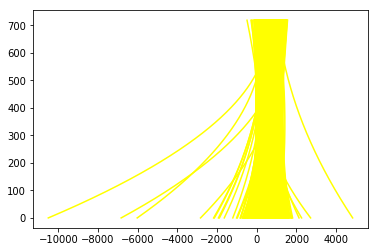

In [107]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

white_output = 'output_images/harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)